<a href="https://colab.research.google.com/github/jhermosillo/keyword_extraction/blob/main/API_TextRank_GFractal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Módulos necesarios

In [1]:
# !pip install deplacy
# !pip install spacy

In [2]:
# !python3 -m spacy download en_core_web_sm
# !python3 -m spacy download es_core_news_sm

In [3]:
import pkg_resources,imp
imp.reload(pkg_resources)

/tmp/ipykernel_3833/801818587.py:1: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import pkg_resources,imp


<module 'pkg_resources' from '/usr/lib/python3/dist-packages/pkg_resources/__init__.py'>

### Librerías necesarias para los algoritmos

In [4]:
from math import *
from math import sqrt
import string
import operator
import random
import pandas as pd
#librerias necesarias para text rank
from collections import OrderedDict
import numpy as np
import spacy

#Listado de STOPWORDS dependiendo del lenguaje
from spacy.lang.en.stop_words import STOP_WORDS
#from spacy.lang.es.stop_words import STOP_WORDS

nlp = spacy.load('en_core_web_sm')
#nlp = spacy.load('es_core_news_sm')

2022-11-15 12:00:29.429268: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-15 12:00:29.429289: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-15 12:00:31.022661: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-15 12:00:31.022684: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-15 12:00:31.022698: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (skywalker): /proc/driver/nvidia/version does not exist


In [5]:
!python3 -m pip install statsmodels # Para importar scoring

In [6]:
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

from keras.models import Sequential
from keras.layers import InputLayer,Dense,Dropout
# from tensorflow.keras.layers import BatchNormalization
from keras.layers import BatchNormalization
from keras.regularizers import l1,l1_l2,l2
from keras.layers import Conv2D, MaxPool2D, Flatten
from keras.utils import np_utils
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import RMSprop
# from keras.optimizers import RMSprop
from keras.layers.advanced_activations import LeakyReLU

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical #TensorFlow V 2.9
# from keras.utils import to_categorical

import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

from scoring import *

# Algoritmo TextRank

In [7]:
class TextRank4Keyword():
    """Extract keywords from text"""

    def __init__(self):
        self.d = 0.85 # damping coefficient, usually is .85
        self.min_diff = 1e-5 # convergence threshold
        self.steps = 100 # iteration steps
        self.node_weight = None # save keywords and its weight

    
    def set_stopwords(self, stopwords):  
        """Set stop words"""
        for word in STOP_WORDS.union(set(stopwords)):
            lexeme = nlp.vocab[word]
            lexeme.is_stop = True
    
    def sentence_segment(self, doc, candidate_pos, lower):
        """Store those words only in cadidate_pos"""
        sentences = []
        for sent in doc.sents:
            selected_words = []
            for token in sent:
                # Store words only with cadidate POS tag
                if token.pos_ in candidate_pos and token.is_stop is False:
                    if lower is True:
                        selected_words.append(token.text.lower())
                    else:
                        selected_words.append(token.text)
            sentences.append(selected_words)
        return sentences
        
    def get_vocab(self, sentences):
        """Get all tokens"""
        vocab = OrderedDict()
        i = 0
        for sentence in sentences:
            for word in sentence:
                if word not in vocab:
                    vocab[word] = i
                    i += 1
        return vocab
    
    def get_token_pairs(self, window_size, sentences):
        """Build token_pairs from windows in sentences"""
        token_pairs = list()
        for sentence in sentences:
            for i, word in enumerate(sentence):
                for j in range(i+1, i+window_size):
                    if j >= len(sentence):
                        break
                    pair = (word, sentence[j])
                    if pair not in token_pairs:
                        token_pairs.append(pair)
        return token_pairs
        
    def symmetrize(self, a):
        return a + a.T - np.diag(a.diagonal())
    
    def get_matrix(self, vocab, token_pairs):
        """Get normalized matrix"""
        # Build matrix
        vocab_size = len(vocab)
        g = np.zeros((vocab_size, vocab_size), dtype='float')
        for word1, word2 in token_pairs:
            i, j = vocab[word1], vocab[word2]
            g[i][j] = 1
            
        # Get Symmeric matrix
        g = self.symmetrize(g)
        
        # Normalize matrix by column
        norm = np.sum(g, axis=0)
        g_norm = np.divide(g, norm, where=norm!=0) # this is ignore the 0 element in norm
        
        return g_norm

    
    def get_keywords(self, number=10):
        """Print top number keywords"""
        keysw={}
        node_weight = OrderedDict(sorted(self.node_weight.items(), key=lambda t: t[1], reverse=True))
        for i, (key, value) in enumerate(node_weight.items()):
            keysw[key] =value
            if i > number:
                break
        return keysw
        
        
    def analyze(self, text, 
                candidate_pos=['NOUN', 'PROPN'], 
                window_size=4, lower=False, stopwords=list()):
        """Main function to analyze text"""
        
        # Set stop words
        self.set_stopwords(stopwords)
        
        # Pare text by spaCy
        doc = nlp(text)
        
        # Filter sentences
        sentences = self.sentence_segment(doc, candidate_pos, lower) # list of list of words
        
        # Build vocabulary
        vocab = self.get_vocab(sentences)
        
        # Get token_pairs from windows
        token_pairs = self.get_token_pairs(window_size, sentences)
        
        # Get normalized matrix
        g = self.get_matrix(vocab, token_pairs)
        
        # Initionlization for weight(pagerank value)
        pr = np.array([1] * len(vocab))
        
        # Iteration
        previous_pr = 0
        for epoch in range(self.steps):
            pr = (1-self.d) + self.d * np.dot(g, pr)
            if abs(previous_pr - sum(pr))  < self.min_diff:
                break
            else:
                previous_pr = sum(pr)

        # Get weight for each node
        node_weight = dict()
        for word, index in vocab.items():
            node_weight[word] = pr[index]
        
        self.node_weight = node_weight
        

# Algoritmo Grado de Fractalidad

In [8]:
#solamente se calcula el grado de fractalidad de las palabras que tengan mas de uno de frecuencia
def fractalidad(palabras,vocabulario,frec,dist):
    N=len(palabras)                                     #El número de tokens de todo el texto
    gf={}
    cajas_index=set()
    voc=[]                                             #la variable voc contendra cada sintagma con frecuencia mayor que 1, por que las otras palabras tendrán 0 de grado de fractaldiad
    for p in vocabulario:                              #Esto se puede hacer fuera del algoritmo, pero se incluye para evitar ese calculo innecesario 
        if(p not in voc):
            if(frec[p]>1):
                if(p not in STOP_WORDS):
                    if(len(p)>1):
                        voc.append(p)
    # print("Text size: ",N)
    # print("Vocabulary: ",len(voc))
    for p in voc:                                  
        rcajas=dist[p]
        M=frec[p]                                  
        dfw=0.0
        nsh=0.0
        for s in range(1,N+1):  
            noc=0                                       
            for e in rcajas:                       
                cajas_index.add(ceil(int(e)/s))    
            noc=len(cajas_index)                    
            cajas_index.clear()    
            ns=N/s
            if(M<=ns):
                nsh=M
            else:
                nsh=M/(1+(M-1)/(N-1)*(s-1)) 
            dfw=dfw+fabs(log(nsh/noc))
        gf[p]=dfw
    return gf    #regresamos un diccionario

In [9]:
def distribucion(palabras,vocabulario):
    N=len(palabras)
    ncajas=[]
    cajas={}
    frecuencias={}
    for p in vocabulario:
        ncajas.clear()
        i=0
        M=palabras.count(p)
        while(i<N):
            if(p == palabras[i]):
                ncajas.append(i+1)
            i=i+1
        frecuencias[p]=M
        cajas[p]=ncajas[:]
    return frecuencias,cajas

# Lectura de archivo de entrada

In [10]:
#Lectura de archivo para generación de vocabulario
def cargar_datos(filename):
    f=open(filename, "r") #tenemos que crear un directorio llamado InputData
    texto=f.read()
    #Pasar a minusculas
    texto=texto.lower()
    #Eliminar puntuación
    texto=texto.translate(str.maketrans('', '', string.punctuation))
    texto=texto.translate(str.maketrans('', '', '¿¡—“”0123456789’'))
    palabras=texto.split()
    textop=""
    #rearmamos el texto debido a ue existen carácteres especiales
    for w in palabras:
        textop=textop+w+' '
    return textop

DEFINICIÓN DEL NOMBRE DEL ARCHIVO A PROCESAR

Lectura de documentos

In [11]:
def lee_documento(filename='NULL',texto=''):
    if filename != 'NULL':
        texto=cargar_datos(filename)
    #obtenemos el vocabulario
    tokens=texto.split()
    vocabulario=[]
    for t in tokens:
        if(t not in vocabulario):
            vocabulario.append(t)
    #variables de procesamiento
    dist={}
    frec={}
    frec,dist=distribucion(tokens,vocabulario)
    return frec,dist,tokens,vocabulario,texto

# Ejecución de algoritmos y generación de archivos de salida

In [12]:
# lectura de documento de prueba
frec,dist,tokens,vocabulario,texto = lee_documento('data.txt')

## Grado de Fractalidad

In [13]:
#ejecución de algoritmo Grado de Fractalidad
def grado_de_fractalidad(tokens,vocabulario,frec,dist,regresa_kw=False,regresa_df=True,top_n=np.inf,escribe_arch=False):
    frac_x=fractalidad(tokens,vocabulario,frec,dist) 
    sorted_x = sorted(frac_x.items(), key=operator.itemgetter(1), reverse=True)
    # print('Time GF: '+str(elapsed_time))

    #Imprimir y guardar resultados de GF
    if regresa_df:
        if top_n != np.inf:
            df=[[t[0],frec[t[0]], t[1], t[1]*log10(frec[t[0]])] for t in sorted_x[:top_n]]
        else:
            df=[[t[0],frec[t[0]], t[1], t[1]*log10(frec[t[0]])] for t in sorted_x]
        #Ordenar resultados por medida combinada
        df.sort(key=lambda x: x[3],reverse=True)
        if regresa_kw==False:
            df = [dato[0] for dato in df]
            by_MC=pd.DataFrame(df, columns=['word'])
        else:   
            by_MC=pd.DataFrame(df, columns=['word','frecuency','Degree_of_fractality','Combined_measure'])
        if escribe_arch:
            by_MC.to_csv('GF.csv')
    else:
        if top_n != np.inf:
            df=[[t[0],frec[t[0]], t[1], t[1]*log10(frec[t[0]])] for t in sorted_x[:top_n]]
        else:
            df=[[t[0],frec[t[0]], t[1], t[1]*log10(frec[t[0]])] for t in sorted_x]
        #Ordenar resultados por medida combinada
        df.sort(key=lambda x: x[3],reverse=True)
        if regresa_kw==False:
            by_MC = [dato[0] for dato in df]
        else:
            by_MC = df
        if escribe_arch:
            print('\nNo se tiene implementada la escritura de archivo cuando regresa_df==False\n')
    return by_MC

def use_gf(texto,regresa_kw=False,regresa_df=False,top_n=np.inf,escribe_arch=False):
    tokens=texto.split()
    vocabulario=[]
    for t in tokens:
        if(t not in vocabulario):
            vocabulario.append(t)
    #variables de procesamiento
    dist={}
    frec={}
    frec,dist=distribucion(tokens,vocabulario)
    df = grado_de_fractalidad(tokens,vocabulario,frec,dist,regresa_kw,regresa_df,top_n,escribe_arch)
    return df

df1 = use_gf(texto,regresa_kw=True,regresa_df=True,top_n=10)
df1

,word,frecuency,Degree_of_fractality,Combined_measure
0,latin,4,167.127394,100.620717
1,content,3,205.903714,98.241038
2,humour,3,163.880039,78.190650
3,injected,3,163.200270,77.866318
4,dummy,2,191.726724,57.715495
5,type,2,191.726724,57.715495
6,line,2,179.412131,54.008433
7,internet,2,175.612973,52.864773
8,reproduced,2,169.604962,51.056181
9,typesetting,2,166.080279,49.995146


## TextRank

In [14]:
#ejecución de algoritmo de TextRank
# start_time = time()
def use_TextRank(texto,regresa_kw=False,regresa_df=False,top_n=np.inf,escribe_arch=False):
    tr4w = TextRank4Keyword()
    tr4w.analyze(texto, candidate_pos = ['NOUN','PROPN'], window_size=4, lower=False)
    kwTR=tr4w.get_keywords(100)

    #Guardar resultados de TextRank
    if regresa_df:
        if top_n!=np.inf:
            if regresa_kw==True:
                salida = [[key, kwTR[key]] for key in kwTR.keys()][:top_n]
                dftr=pd.DataFrame(salida, columns=['word', 'Index'])
            else:
                salida = list(kwTR.keys())[:top_n]
                dftr=pd.DataFrame(salida, columns=['word'])
        else:
            if regresa_kw==True:
                salida = [[key, kwTR[key]] for key in kwTR.keys()]
                dftr=pd.DataFrame(salida, columns=['word', 'Index'])
            else:
                salida = list(kwTR.keys())
                dftr=pd.DataFrame(salida, columns=['word'])
    else:
        if top_n!=np.inf:
            if regresa_kw==True:
                dftr = [[key, kwTR[key]] for key in kwTR.keys()][:top_n]
            else:
                dftr = list(kwTR.keys())[:top_n]
        else:
            if regresa_kw==True:
                dftr = [[key, kwTR[key]] for key in kwTR.keys()]
            else:
                dftr = list(kwTR.keys())
        # elapsed_time = time() - start_time
        # print('Time TextRank: '+str(elapsed_time))
        if escribe_arch:
            dftr.to_csv('TextRank.csv')
    return dftr

dftr = use_TextRank(texto,top_n=10)
dftr

['ipsum',
 'lorem',
 'words',
 'versions',
 's',
 'text',
 'bc',
 'book',
 'humour',
 'years']

# 20 Newsgroups

In [15]:
def preprocess_text(r,remove_STW=True,lemmatize=False):
    def check_STW(palabras):
        texto = [w for w in palabras \
                 if not w in STOP_WORDS and len(w)>2]
        return texto
    def remove_basura(palabras):
        #basura = pd.read_csv('basura.txt',sep='\n',names=['words']) # El separador \n marca ValueError
        basura = pd.read_csv('basura.txt',names=['words'])
        basura = basura.words.tolist()
        texto = [w for w in palabras if not w in basura]
        return texto        
    r1=r.cadena.str.translate(\
          str.maketrans('','',string.digits))\
          .str.translate(\
          str.maketrans('','',string.punctuation))\
          .str.replace('«','', regex=True)\
          .str.replace('»','', regex=True).str.replace('(','', regex=True)\
          .str.replace('\n',' ', regex=True)\
          .str.replace(')','', regex=True).str.strip().str.lower()
    if remove_STW:
        r1=r1.to_frame().applymap(lambda x : x.split()).applymap(check_STW).applymap(lambda x: ' '.join(x))
        r1=r1.applymap(lambda x : x.split()).applymap(remove_basura).applymap(lambda x: ' '.join(x))
    if lemmatize:
        if isinstance(r1, pd.DataFrame):
            r1=r1.applymap(lambda x : nlp(x)).applymap(lambda x: ' '.join([token.lemma_ for token in x]))        
        else:
            r1=r1.to_frame().applymap(lambda x : nlp(x)).applymap(lambda x: ' '.join([token.lemma_ for token in x]))        
    r.cadena = r1
    r=r.rename(columns={'cadena':'docs'})
    return r

### Aqui empieza lo que tengo que ver que funcione

In [16]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train',remove=('headers', 'footers', 'quotes'))

from pprint import pprint
# pprint(list(newsgroups_train.target_names))

cats=list(newsgroups_train.target_names)
n = len(cats)//2
cats1=cats[:n]
cats2=cats[n:]
# print(cats)
print(cats1)
print(cats2)
categories = [cats1,cats2]

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball']
['rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [17]:
def process_20NG(categories,n=20,th=5,remove_STW=True,lemmatize=False):
    data=[]
    for i,cats in enumerate(categories):
        newsgroups_train = fetch_20newsgroups(subset='train', 
                                        remove=('headers', 'footers', 'quotes'),
                                        categories=cats)
        df = pd.DataFrame(newsgroups_train.data, columns=['cadena'])
        df['target'] = pd.Series(newsgroups_train.target+len(cats)*i)
        df = preprocess_text(df,remove_STW=remove_STW,lemmatize=lemmatize)
        df['TR'] = df.docs.apply(lambda x : use_TextRank(x,top_n=n))
        df['GF'] = df.docs.apply(lambda x : use_gf(x,top_n=n))
        df=df.drop(df[df.TR.apply(lambda x: len(x)<th)].index).reset_index(drop=True)
        df=df.drop(df[df.GF.apply(lambda x: len(x)<th)].index).reset_index(drop=True)
        data.append(df)
    lista=range(len(categories))
    newsgroups_data = data[0]
    if len(lista)>1:
        for j in lista[1:]:
            newsgroups_data = newsgroups_data.append(data[j],ignore_index=True)
    newsgroups_data = newsgroups_data.sample(frac=1).reset_index(drop=True)
    # newsgroups_data.to_csv('newsgroups_train_data.csv')
    return newsgroups_data

In [18]:
newsgroups_train_data = process_20NG(categories,n=100,remove_STW=True,lemmatize=True)
newsgroups_train_data

/tmp/ipykernel_3833/3745100282.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  newsgroups_data = newsgroups_data.append(data[j],ignore_index=True)


,docs,target,TR,GF
0,similarly people usually use dbm common mistak...,12,"[company, bell, amp, unit, decibell, msc, pasa...","[bell, ampere, company, amp, current, actually..."
1,white house office press secretary pittsburgh ...,18,"[people, president, officer, country, job, bil...","[officer, senator, bill, pittsburgh, people, p..."
2,interesting article craig amazing hard basebal...,9,"[game, growth, business, century, baseball, ow...","[game, team, owner, growth, business, century,..."
3,like switch floppy drive drive have problem kn...,3,"[drive, change, type, pos, switch, light, cmos...","[drive, light, pos, type, come, switch, correc..."
4,hello you re sure that s joke read article you...,3,"[manufacturer, spec, information, joke, list, ...","[harddisk, ide, manufacturer, joke, read]"
...,...,...,...,...
4913,buy new car finance pay cash car buy worry goo...,7,"[car, insurance, bank, type, loan, dealer, ext...","[car, bank, buy, insurance, pay, want, dealer,..."
4914,interesting brief selection post net understan...,15,"[church, overacker, lloshellcom, sspx, excommu...","[overacker, lloshellcom, excommunication, cons..."
4915,long folk share esteemed wisdom lil karnak sez...,9,"[san, york, chicago, new, west, east, bit, lil...","[east, west, san, york, new, chicago]"
4916,ethnocentric usian I ve assume xussr country s...,14,"[radar, satellite, japan, antenna, tracking, d...","[radar, satellite, antenna, optical, system, t..."


In [19]:
print(np.unique(newsgroups_train_data.target))
print(newsgroups_train_data.GF.values[:5])
print(newsgroups_train_data.TR.values[:5])
df = newsgroups_train_data.copy()
df

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[list(['bell', 'ampere', 'company', 'amp', 'current', 'actually', 'use', 'right', 'decibell', 'thing', 'unit'])
 list(['officer', 'senator', 'bill', 'pittsburgh', 'people', 'president', 'think', 'trial', 'thing', 'year', 'budget', 'vote', 'reform', 'kdka', 'police', 'know', 'republicans', 've', 'jury', 'pass', 'lot', 'los', 'angeles', 'look', 'work', 'pennsylvania', 'like', 'city', 'sergeant', 'whitely', 'airport', 'international', 'mike', 'news', 'republican', 'radio', 'battle', 'cut', 'support', 'pay', 'believe', 'congress', 'specter', 'bring', 'spending', 'investment', 'house', 'economic', 'want', 'wonder', 'target', 'hope', 'big', 'area', 'real', 'money', 'white', 'going', 'state', 'resolution', 'find', 'increase', 'guilty', 'judgment', 'deficit', 'particular', 'half', 'fast', 'importance', 'allegheny', 'county', 'situation', 'turn', 'right', 'hold', 'life', 'violate', 'crime', 'civil', 'overnight', 'renew', 'need', 'pla

,docs,target,TR,GF
0,similarly people usually use dbm common mistak...,12,"[company, bell, amp, unit, decibell, msc, pasa...","[bell, ampere, company, amp, current, actually..."
1,white house office press secretary pittsburgh ...,18,"[people, president, officer, country, job, bil...","[officer, senator, bill, pittsburgh, people, p..."
2,interesting article craig amazing hard basebal...,9,"[game, growth, business, century, baseball, ow...","[game, team, owner, growth, business, century,..."
3,like switch floppy drive drive have problem kn...,3,"[drive, change, type, pos, switch, light, cmos...","[drive, light, pos, type, come, switch, correc..."
4,hello you re sure that s joke read article you...,3,"[manufacturer, spec, information, joke, list, ...","[harddisk, ide, manufacturer, joke, read]"
...,...,...,...,...
4913,buy new car finance pay cash car buy worry goo...,7,"[car, insurance, bank, type, loan, dealer, ext...","[car, bank, buy, insurance, pay, want, dealer,..."
4914,interesting brief selection post net understan...,15,"[church, overacker, lloshellcom, sspx, excommu...","[overacker, lloshellcom, excommunication, cons..."
4915,long folk share esteemed wisdom lil karnak sez...,9,"[san, york, chicago, new, west, east, bit, lil...","[east, west, san, york, new, chicago]"
4916,ethnocentric usian I ve assume xussr country s...,14,"[radar, satellite, japan, antenna, tracking, d...","[radar, satellite, antenna, optical, system, t..."


In [20]:
newsgroups_train_data.to_pickle('newsgroups_train_data_sinSW_lemma_Top100.pickle')

## Lectura de archivo procesado

In [21]:
df = pd.read_pickle('newsgroups_train_data_sinSW_lemma_Top100.pickle')
df

,docs,target,TR,GF
0,similarly people usually use dbm common mistak...,12,"[company, bell, amp, unit, decibell, msc, pasa...","[bell, ampere, company, amp, current, actually..."
1,white house office press secretary pittsburgh ...,18,"[people, president, officer, country, job, bil...","[officer, senator, bill, pittsburgh, people, p..."
2,interesting article craig amazing hard basebal...,9,"[game, growth, business, century, baseball, ow...","[game, team, owner, growth, business, century,..."
3,like switch floppy drive drive have problem kn...,3,"[drive, change, type, pos, switch, light, cmos...","[drive, light, pos, type, come, switch, correc..."
4,hello you re sure that s joke read article you...,3,"[manufacturer, spec, information, joke, list, ...","[harddisk, ide, manufacturer, joke, read]"
...,...,...,...,...
4913,buy new car finance pay cash car buy worry goo...,7,"[car, insurance, bank, type, loan, dealer, ext...","[car, bank, buy, insurance, pay, want, dealer,..."
4914,interesting brief selection post net understan...,15,"[church, overacker, lloshellcom, sspx, excommu...","[overacker, lloshellcom, excommunication, cons..."
4915,long folk share esteemed wisdom lil karnak sez...,9,"[san, york, chicago, new, west, east, bit, lil...","[east, west, san, york, new, chicago]"
4916,ethnocentric usian I ve assume xussr country s...,14,"[radar, satellite, japan, antenna, tracking, d...","[radar, satellite, antenna, optical, system, t..."


In [22]:
df = df.drop(df[df.TR.apply(lambda x: len(x)<5)].index).reset_index(drop=True)
df = df.drop(df[df.GF.apply(lambda x: len(x)<5)].index).reset_index(drop=True)
df

,docs,target,TR,GF
0,similarly people usually use dbm common mistak...,12,"[company, bell, amp, unit, decibell, msc, pasa...","[bell, ampere, company, amp, current, actually..."
1,white house office press secretary pittsburgh ...,18,"[people, president, officer, country, job, bil...","[officer, senator, bill, pittsburgh, people, p..."
2,interesting article craig amazing hard basebal...,9,"[game, growth, business, century, baseball, ow...","[game, team, owner, growth, business, century,..."
3,like switch floppy drive drive have problem kn...,3,"[drive, change, type, pos, switch, light, cmos...","[drive, light, pos, type, come, switch, correc..."
4,hello you re sure that s joke read article you...,3,"[manufacturer, spec, information, joke, list, ...","[harddisk, ide, manufacturer, joke, read]"
...,...,...,...,...
4913,buy new car finance pay cash car buy worry goo...,7,"[car, insurance, bank, type, loan, dealer, ext...","[car, bank, buy, insurance, pay, want, dealer,..."
4914,interesting brief selection post net understan...,15,"[church, overacker, lloshellcom, sspx, excommu...","[overacker, lloshellcom, excommunication, cons..."
4915,long folk share esteemed wisdom lil karnak sez...,9,"[san, york, chicago, new, west, east, bit, lil...","[east, west, san, york, new, chicago]"
4916,ethnocentric usian I ve assume xussr country s...,14,"[radar, satellite, japan, antenna, tracking, d...","[radar, satellite, antenna, optical, system, t..."


# Distribución del vocabulario (no correr)

In [23]:
from nltk.tokenize import word_tokenize

textos = df['TR'].values.tolist()
t = ' '.join(textos[0])
for l in textos[1:]:
    t += ' '.join(l)
vocTR = set(word_tokenize(t))
print(len(vocTR),'palabras únicas (tipos)')

36712 palabras únicas (tipos)


In [24]:
textos = df['GF'].values.tolist()
t = ' '.join(textos[0])
for l in textos[1:]:
    t += ' '.join(l)
vocGF = set(word_tokenize(t))
print(len(vocGF),'palabras únicas (tipos)')

18692 palabras únicas (tipos)


In [25]:
basura = []
for w in vocTR:
    if len(w) > 12:
        basura.append(w)
TRvoc = []
for w in vocTR:
    if w not in basura:
        TRvoc.append(w)
print(len(TRvoc))
np.savetxt('basura_TR.txt',basura,fmt = '%s',delimiter=',')

33492


In [26]:
basura = []
for w in vocGF:
    if len(w) > 12:
        basura.append(w)
GFvoc = []
for w in vocGF:
    if w not in basura:
        GFvoc.append(w)
print(len(GFvoc))
np.savetxt('basura_GF.txt',basura,fmt = '%s',delimiter=',')

16833


In [27]:
#basura_TR = pd.read_csv('basura_TR.txt',sep='\n',names=['words']) # Value error with sep='\n'
basura_TR = pd.read_csv('basura_TR.txt',names=['words'])
#basura_GF = pd.read_csv('basura_GF.txt',sep='\n',names=['words']) # Value error with sep='\n'
basura_GF = pd.read_csv('basura_GF.txt',names=['words'])
basura = pd.concat([basura_TR,basura_GF])
basura = basura.words.tolist()

np.savetxt('basura.txt',basura,fmt = '%s',delimiter=',')

In [28]:
vocINTER = list(set(TRvoc).intersection(set(GFvoc)))
print(len(vocINTER))

11360


# Word2vec

In [29]:
# import modules & set up logging
from gensim.models import Word2Vec as w2v
import gensim.downloader as api

def vocdf(df,vec_size=100):
    # obtain vocabulary word types 
    types=df['docs'].str.split(' ', expand=True).stack().unique()
    # Data Frame of vocabulary and word embeddings
    typesDF=pd.Series(types).to_frame()
    typesDF.rename(index=int,columns={0:'Palabra'},inplace=True)

    #Add Emebddings placeholders
    #Se necesita convertir el DF a diccionario
    #luego se agregan vectores de dimension N,
    #como registros nuevos del diccionario
    #para reconvertirlo en un DF de vuelta
    dico=typesDF.to_dict('records',into=OrderedDict)
    #Add real-valued embedding vectors
    for reg in dico:
        reg['W2V']=np.zeros(vec_size)
    typesDF=pd.DataFrame.from_dict(dico)
    typesDF.set_index('Palabra',inplace=True)
    return typesDF 

def compute_embeddings(df,typesdf,vec_dim=100):
    
    docs = df["docs"].values.tolist()
    docs = [s.split() for s in docs]
    model = w2v(docs, min_count=1, vector_size=vec_dim)
    words = typesdf.index.values.tolist()
    for w in words:
        typesdf.at[w,'W2V'] = model.wv[w]
    return model

typesDF = vocdf(df)
print(typesDF.iloc[0].W2V.shape)

modelo = compute_embeddings(df,typesDF)
print(typesDF.loc['sound'])
typesDF.to_pickle('typesDF_WE.pickle')
typesDF.head()
# model.wv['sound']
# model.wv.most_similar('good', topn=10) 

(100,)
W2V    [-0.004175084, 1.6214749, 0.51203877, 0.232613...
Name: sound, dtype: object


,W2V
Palabra,
similarly,"[-0.20331828, 0.33548576, 0.31964448, 0.058859..."
people,"[-0.67618316, 1.8555644, 0.83009213, 1.5577912..."
usually,"[-0.1687841, 0.992912, 0.7024177, 0.09315095, ..."
use,"[0.34647635, 0.95796937, 1.0622741, -1.2089946..."
dbm,"[-0.014101019, 0.05659094, 0.026170347, -0.017..."


In [30]:
vectores = {}

for index, strings in typesDF.iterrows():
    vectores[index] = strings[0]


In [299]:
vectores['countersteer']

array([-0.01255261,  0.03800226,  0.02734813, -0.0035886 ,  0.00569415,
       -0.03420107,  0.03466104,  0.04603254, -0.03079284, -0.00399047,
       -0.00872742, -0.04960322, -0.00035968,  0.01660641,  0.0108748 ,
       -0.02007056,  0.02479238, -0.00911835, -0.00912374, -0.01966357,
        0.01306345,  0.01703718,  0.02109896, -0.02756155,  0.00214337,
        0.02869198, -0.03573067, -0.01976767, -0.03614445, -0.00844718,
        0.01934046, -0.00145381,  0.02574017, -0.02640318,  0.00313019,
        0.02619875, -0.00299612, -0.01270271,  0.00616508, -0.02144887,
       -0.0027859 , -0.03403967, -0.00139844,  0.00164688,  0.00790535,
       -0.01241099, -0.01482694, -0.01462339,  0.00174294,  0.01850464,
       -0.00074917, -0.01785518, -0.01776141,  0.01827146, -0.0342186 ,
        0.01447373,  0.00429573, -0.02151056, -0.02851713, -0.00398995,
        0.00773562,  0.01489231,  0.01863283,  0.00433116, -0.02492635,
        0.0401334 ,  0.0181694 ,  0.01232284, -0.04337481,  0.02

In [32]:
# print(new_df.TR.values)


In [33]:
typesDF = pd.read_pickle('typesDF_WE.pickle')
typesDF.head()

,W2V
Palabra,
similarly,"[-0.20331828, 0.33548576, 0.31964448, 0.058859..."
people,"[-0.67618316, 1.8555644, 0.83009213, 1.5577912..."
usually,"[-0.1687841, 0.992912, 0.7024177, 0.09315095, ..."
use,"[0.34647635, 0.95796937, 1.0622741, -1.2089946..."
dbm,"[-0.014101019, 0.05659094, 0.026170347, -0.017..."


# Separacion de dataframe por clase

## Ahora para todas las clases

In [34]:
from collections import Counter

In [35]:
def top100_clase(data_frame, clase, algoritmo):
    '''Función que genera el vocabulario de las Top 100 palabras de una clase y de un algoritmo específico, dado una DataFrame.

    data_frame: La DataFrame de la cual provienen los documentos.
    clase: La clase de documento del cual queremos obtener las palabras.
    algoritmo: El algoritmo del cual queremos obtener las palabras. 0 para TextRank, 1 para Grado de Fractalidad'''

    df_clase = data_frame.drop(data_frame[data_frame.target != clase].index) # Obtenemos los documentos de la clase que requerimos
    if algoritmo == 0: # Usando el algoritmo TextRank
        text = df_clase.TR.values
    if algoritmo == 1: # Usando el algoritmo Grado de Fractalidad
        text = df_clase.GF.values

    palabras = []
    for d in text: # Obtenemos todas las palabras obtenidas por el algoritmo
        for palabra in d:
            palabras.append(palabra)
    palabras = Counter(palabras) # Contamos la frecuencia de cada palabra

    top = pd.DataFrame(palabras.items(), columns=['Palabra','Frecuencia']) 
    top = top.sort_values(by=['Frecuencia'],ascending=False) # Ordenamos por frecuencia de orden descendente
    top = top.reset_index(drop=True) 
    top = top[:100]

    tem = top.copy() # Creamos un DataFrame temporal
    top['Vector'] = "" # Creamos una nueva columna, por el momento vacía

    for index, strings in tem.iterrows(): # Para cada indice y string, iteramos en las filas de tem (DataFrame temporal)
        top.at[index,'Vector'] = vectores[strings[0]] # Añadimos el vector correspondiente a la palabra en su indice dado

    return top # Regresamos los primeros 100 elementos 

In [185]:
df_vect = pd.read_pickle('newsgroups_train_data_sinSW_lemma_Top100.pickle')

df_vect = df_vect.drop(df[df.TR.apply(lambda x: len(x)<5)].index).reset_index(drop=True)
df_vect = df_vect.drop(df[df.GF.apply(lambda x: len(x)<5)].index).reset_index(drop=True)

### Algunos tests de la funcion top100_clase

In [186]:
voc_c1_tr = top100_clase(df, 1, 0) # Generamos el top 100 de la clase 2 con el algoritmo Text Rank
voc_c1_tr

,Palabra,Frecuencia,Vector
0,file,49,"[1.0800244, 0.3087293, 1.5997304, -3.0298579, ..."
1,image,43,"[0.19544502, 0.4509359, 0.53990316, -1.5684794..."
2,program,42,"[0.62990636, 1.0053309, 0.38436267, -1.512629,..."
3,computer,37,"[0.1358879, 0.48722842, 0.61875623, -1.3347471..."
4,use,35,"[0.34647635, 0.95796937, 1.0622741, -1.2089946..."
...,...,...,...
95,research,10,"[-0.5181131, -0.08190754, 0.34965667, -0.20493..."
96,machine,10,"[0.44158828, 1.4556292, 0.9116822, -1.3547492,..."
97,method,10,"[-0.2480886, 0.403423, 0.7452466, -0.3308399, ..."
98,edge,10,"[-0.009610891, 0.8394367, 0.24289913, -0.17314..."


In [187]:
# Como utilizar W2V para obtener los vectores de una palabra específica

tem = voc_c1_tr.copy() # Creamos un DataFrame temporal
voc_c1_tr['Vector'] = "" # Creamos una nueva columna, por el momento vacía

for index, strings in tem.iterrows(): # Para cada indice y string, iteramos en las filas de tem (DataFrame temporal)
    voc_c1_tr.at[index,'Vector'] = vectores[strings[0]] # Añadimos el vector correspondiente a la palabra en su indice dado


# voc_c1_tr.assign(Vector = lambda x: vectores[x])

In [188]:
voc_c1_tr # Revisamos el dataframe con su nueva columna de Vector, ya llena

,Palabra,Frecuencia,Vector
0,file,49,"[1.0800244, 0.3087293, 1.5997304, -3.0298579, ..."
1,image,43,"[0.19544502, 0.4509359, 0.53990316, -1.5684794..."
2,program,42,"[0.62990636, 1.0053309, 0.38436267, -1.512629,..."
3,computer,37,"[0.1358879, 0.48722842, 0.61875623, -1.3347471..."
4,use,35,"[0.34647635, 0.95796937, 1.0622741, -1.2089946..."
...,...,...,...
95,research,10,"[-0.5181131, -0.08190754, 0.34965667, -0.20493..."
96,machine,10,"[0.44158828, 1.4556292, 0.9116822, -1.3547492,..."
97,method,10,"[-0.2480886, 0.403423, 0.7452466, -0.3308399, ..."
98,edge,10,"[-0.009610891, 0.8394367, 0.24289913, -0.17314..."


In [189]:
top100_clase(df,12,1).head(20)

,Palabra,Frecuencia,Vector
0,use,31,"[0.34647635, 0.95796937, 1.0622741, -1.2089946..."
1,good,21,"[-0.8350045, 1.500034, 0.5697813, 1.8845841, -..."
2,work,20,"[0.07281874, 1.4096147, 0.8419353, -0.06121675..."
3,high,19,"[0.4288609, 1.8552574, -0.2304232, -0.17397185..."
4,power,19,"[0.10794014, 1.4591955, -0.08183818, 0.2327865..."
5,chip,19,"[0.4785471, 1.0464389, 1.4359117, -1.4167892, ..."
6,like,18,"[-0.33474594, 1.8091434, 0.35017183, 0.7168113..."
7,know,16,"[-0.5945551, 1.8782849, 1.4943341, 0.25249392,..."
8,circuit,16,"[0.09833243, 0.82523465, 0.42215574, -0.399916..."
9,current,16,"[0.245862, 0.9265248, 0.5626679, -0.8038486, 0..."


In [190]:
test = df_vect.sample(frac=0.2) # Separamos al Train y Test en un 80/20
df_vect = df_vect.drop(labels=test.index)

test

,docs,target,TR,GF
2120,maciifx know wire scsi chain buy drive need fi...,4,"[question, scsi, iifx, chain, spec, answer, bu...","[know, question, scsi, want, iifx, answer, spe..."
3801,look like go couple bike storage month start m...,8,"[battery, month, storage, bike, leave, contain...","[month, battery, leave, container, storage, bi..."
2076,die cause run risk die lie people able tell li...,0,"[liar, god, time, course, evidence, logic, bib...","[bible, die, total, time, quote, logic, suppor..."
4379,live thing maintain small electric field enhan...,13,"[field, system, activity, organism, healing, b...","[field, electric, picture, cell, activity, und..."
163,interested new ati ultra card post question ne...,2,"[card, ati, mode, isa, version, memory, bit, s...","[card, ati, ultra, fast, isa, video, problem, ..."
...,...,...,...,...
117,be not original intent reverse light driver ba...,7,"[car, path, reverse, driver, intent, color]","[car, intent, reverse, light, original]"
1163,science progress experimentation philosophise ...,15,"[world, model, science, claim, observation, ex...","[model, assumption, observation, claim, world,..."
3371,fyii post altpsychoactive response group note ...,13,"[group, article, scime, note, time, bill, deci...","[group, altpsychoactive, etc, start, article, ..."
89,text delete wish follow thread jump conclusion...,15,"[god, sin, people, love, aid, jesus, way, issu...","[god, aid, love, sin, forgive, way, angry, cur..."


In [191]:
df_vect = df_vect.reset_index(drop=True)
test = test.reset_index(drop=True)

In [192]:
test

,docs,target,TR,GF
0,maciifx know wire scsi chain buy drive need fi...,4,"[question, scsi, iifx, chain, spec, answer, bu...","[know, question, scsi, want, iifx, answer, spe..."
1,look like go couple bike storage month start m...,8,"[battery, month, storage, bike, leave, contain...","[month, battery, leave, container, storage, bi..."
2,die cause run risk die lie people able tell li...,0,"[liar, god, time, course, evidence, logic, bib...","[bible, die, total, time, quote, logic, suppor..."
3,live thing maintain small electric field enhan...,13,"[field, system, activity, organism, healing, b...","[field, electric, picture, cell, activity, und..."
4,interested new ati ultra card post question ne...,2,"[card, ati, mode, isa, version, memory, bit, s...","[card, ati, ultra, fast, isa, video, problem, ..."
...,...,...,...,...
979,be not original intent reverse light driver ba...,7,"[car, path, reverse, driver, intent, color]","[car, intent, reverse, light, original]"
980,science progress experimentation philosophise ...,15,"[world, model, science, claim, observation, ex...","[model, assumption, observation, claim, world,..."
981,fyii post altpsychoactive response group note ...,13,"[group, article, scime, note, time, bill, deci...","[group, altpsychoactive, etc, start, article, ..."
982,text delete wish follow thread jump conclusion...,15,"[god, sin, people, love, aid, jesus, way, issu...","[god, aid, love, sin, forgive, way, angry, cur..."


In [193]:
df_vect

,docs,target,TR,GF
0,white house office press secretary pittsburgh ...,18,"[people, president, officer, country, job, bil...","[officer, senator, bill, pittsburgh, people, p..."
1,interesting article craig amazing hard basebal...,9,"[game, growth, business, century, baseball, ow...","[game, team, owner, growth, business, century,..."
2,hello you re sure that s joke read article you...,3,"[manufacturer, spec, information, joke, list, ...","[harddisk, ide, manufacturer, joke, read]"
3,function sophisticated one level control groun...,12,"[mixer, gnd, keyboard, transformer, ratio, tur...","[gnd, hot, ratio, mixer, transformer, groundli..."
4,couple thing post thread little confusing athe...,0,"[value, god, thing, event, morality, way, poin...","[value, view, moral, god, thing, point, perspe..."
...,...,...,...,...
3929,buy new car finance pay cash car buy worry goo...,7,"[car, insurance, bank, type, loan, dealer, ext...","[car, bank, buy, insurance, pay, want, dealer,..."
3930,interesting brief selection post net understan...,15,"[church, overacker, lloshellcom, sspx, excommu...","[overacker, lloshellcom, excommunication, cons..."
3931,long folk share esteemed wisdom lil karnak sez...,9,"[san, york, chicago, new, west, east, bit, lil...","[east, west, san, york, new, chicago]"
3932,ethnocentric usian I ve assume xussr country s...,14,"[radar, satellite, japan, antenna, tracking, d...","[radar, satellite, antenna, optical, system, t..."


In [194]:
voc100_TR_clases = []
voc100_GF_clases = []

for j in range(20):
    voc = top100_clase(df, j, 0)
    voc100_TR_clases.append(voc['Palabra'])
    voc = top100_clase(df, j, 1)
    voc100_GF_clases.append(voc['Palabra'])

### Ahora añadimos las vectorizaciones de las palabras para cada documento, según el algoritmo ocupado y su clase.

In [197]:
print(df_vect.iloc[0][3])

['officer', 'senator', 'bill', 'pittsburgh', 'people', 'president', 'think', 'trial', 'thing', 'year', 'budget', 'vote', 'reform', 'kdka', 'police', 'know', 'republicans', 've', 'jury', 'pass', 'lot', 'los', 'angeles', 'look', 'work', 'pennsylvania', 'like', 'city', 'sergeant', 'whitely', 'airport', 'international', 'mike', 'news', 'republican', 'radio', 'battle', 'cut', 'support', 'pay', 'believe', 'congress', 'specter', 'bring', 'spending', 'investment', 'house', 'economic', 'want', 'wonder', 'target', 'hope', 'big', 'area', 'real', 'money', 'white', 'going', 'state', 'resolution', 'find', 'increase', 'guilty', 'judgment', 'deficit', 'particular', 'half', 'fast', 'importance', 'allegheny', 'county', 'situation', 'turn', 'right', 'hold', 'life', 'violate', 'crime', 'civil', 'overnight', 'renew', 'need', 'plan', 'political', 'economy', 'clinton', 'states', 'united', 'thank', 'create', 'happen', 'ought', 'care', 'health', 'approve', 'ask', 'operation', 'change', 'present', 'effort']


In [198]:
len(df_vect.iloc[0][3])

100

In [47]:
df_vect.head(10)

,docs,target,TR,GF
0,similarly people usually use dbm common mistak...,12,"[company, bell, amp, unit, decibell, msc, pasa...","[bell, ampere, company, amp, current, actually..."
1,white house office press secretary pittsburgh ...,18,"[people, president, officer, country, job, bil...","[officer, senator, bill, pittsburgh, people, p..."
2,like switch floppy drive drive have problem kn...,3,"[drive, change, type, pos, switch, light, cmos...","[drive, light, pos, type, come, switch, correc..."
3,function sophisticated one level control groun...,12,"[mixer, gnd, keyboard, transformer, ratio, tur...","[gnd, hot, ratio, mixer, transformer, groundli..."
4,cor judge come judgment judge lord discipled c...,15,"[lord, jude, judge, judgment, arrogance, sign,...","[ungodly, cor, judgment, judge, slow, sign, lo..."
5,couple thing post thread little confusing athe...,0,"[value, god, thing, event, morality, way, poin...","[value, view, moral, god, thing, point, perspe..."
6,actually accelerator daystar mhz cheap upgradi...,4,"[video, upgrade, bit, mhz, cost, accelerator, ...","[accelerator, upgrade, depth, mhz, cost, bit, ..."
7,dragon lair complete laser disc motherboardjoy...,6,"[laserdisc, system, player, cabinet, house, ga...","[run, system, laserdisc, soren, cabinet, playe..."
8,togglebutton widget yes widget routine change ...,5,"[xsendevent, example, label, change, redraw, t...","[xsendevent, widget, background, label, redraw..."
9,think kind people world think kind people do n...,8,"[weather, world, snow, flurry, people, obmoto,...","[kind, people, think, weather, world]"


In [48]:
#np.zeros((100,100), dtype=float)

In [199]:
''' Forma más rápida de obtener top 100 palabras vectorizadas, regresa valores mas pequeños de las palabras vectorizadas '''

df_vect['VTR'] = ""
df_vect['VGF'] = ""

for index, row in df_vect.iterrows():

    df_vect._set_value(index, 'VTR', np.zeros((100,100),dtype=float))
    df_vect._set_value(index, 'VGF', np.zeros((100,100),dtype=float))

    clase = row.target
    temp_list = []
    for j in range(100):
        if voc100_TR_clases[clase][j] in row.TR:
            temp_list.append(vectores[voc100_TR_clases[clase][j]])
        else:
            temp_list.append(np.zeros(100))
    df_vect._set_value(index, 'VTR', temp_list)
    temp_list = []
    for j in range(100):
        if voc100_GF_clases[clase][j] in row.GF:
            temp_list.append(vectores[voc100_GF_clases[clase][j]])
        else:
            temp_list.append(np.zeros(100))
    df_vect._set_value(index, 'VGF', temp_list)

In [200]:
df_vect

,docs,target,TR,GF,VTR,VGF
0,white house office press secretary pittsburgh ...,18,"[people, president, officer, country, job, bil...","[officer, senator, bill, pittsburgh, people, p...","[[-0.67618316, 1.8555644, 0.83009213, 1.557791...","[[-0.67618316, 1.8555644, 0.83009213, 1.557791..."
1,interesting article craig amazing hard basebal...,9,"[game, growth, business, century, baseball, ow...","[game, team, owner, growth, business, century,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,hello you re sure that s joke read article you...,3,"[manufacturer, spec, information, joke, list, ...","[harddisk, ide, manufacturer, joke, read]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,function sophisticated one level control groun...,12,"[mixer, gnd, keyboard, transformer, ratio, tur...","[gnd, hot, ratio, mixer, transformer, groundli...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,couple thing post thread little confusing athe...,0,"[value, god, thing, event, morality, way, poin...","[value, view, moral, god, thing, point, perspe...","[[-0.67618316, 1.8555644, 0.83009213, 1.557791...","[[-3.1327872, 0.29301494, 0.9826382, 2.353847,..."
...,...,...,...,...,...,...
3929,buy new car finance pay cash car buy worry goo...,7,"[car, insurance, bank, type, loan, dealer, ext...","[car, bank, buy, insurance, pay, want, dealer,...","[[0.2972849, 2.475763, 0.62475806, -0.1479278,...","[[0.2972849, 2.475763, 0.62475806, -0.1479278,..."
3930,interesting brief selection post net understan...,15,"[church, overacker, lloshellcom, sspx, excommu...","[overacker, lloshellcom, excommunication, cons...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3931,long folk share esteemed wisdom lil karnak sez...,9,"[san, york, chicago, new, west, east, bit, lil...","[east, west, san, york, new, chicago]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3932,ethnocentric usian I ve assume xussr country s...,14,"[radar, satellite, japan, antenna, tracking, d...","[radar, satellite, antenna, optical, system, t...","[[0.42694762, 0.3861184, 0.48250258, -0.917654...","[[0.42694762, 0.3861184, 0.48250258, -0.917654..."


In [202]:
len(df_vect.iloc[0].VTR)

100

In [203]:
df_vect.dtypes

docs      object
target     int64
TR        object
GF        object
VTR       object
VGF       object
dtype: object

In [52]:
''' Forma mas lenta de obtener top 100 palabras vectorizadas, regresa valores mas grandes de la palabra vectorizada '''
temp = df_vect.copy()
df_vect['VTR'] = ""
df_vect['VGF'] = ""

for i in range(len(temp)):
    clase = df_vect['target'][i]
    df_vect['VTR'][i] = np.zeros((100,100),dtype=float)
    for j in range(100):
        for palabra in df_vect.iloc[i][2]:
            if voc100_TR_clases[clase][j] == palabra:
                df_vect['VTR'][i][j] = vectores[voc100_TR_clases[clase][j]]
    df_vect['VGF'][i] = np.zeros((100,100),dtype=float)
    for j in range(100):
        for palabra in df_vect.iloc[i][3]:
            if voc100_GF_clases[clase][j] == palabra:
                df_vect['VGF'][i][j] = vectores[voc100_GF_clases[clase][j]]


/tmp/ipykernel_3833/4209427495.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vect['VTR'][i] = np.zeros((100,100),dtype=float)
/tmp/ipykernel_3833/4209427495.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vect['VGF'][i] = np.zeros((100,100),dtype=float)


In [204]:
df_vect

,docs,target,TR,GF,VTR,VGF
0,white house office press secretary pittsburgh ...,18,"[people, president, officer, country, job, bil...","[officer, senator, bill, pittsburgh, people, p...","[[-0.67618316, 1.8555644, 0.83009213, 1.557791...","[[-0.67618316, 1.8555644, 0.83009213, 1.557791..."
1,interesting article craig amazing hard basebal...,9,"[game, growth, business, century, baseball, ow...","[game, team, owner, growth, business, century,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,hello you re sure that s joke read article you...,3,"[manufacturer, spec, information, joke, list, ...","[harddisk, ide, manufacturer, joke, read]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,function sophisticated one level control groun...,12,"[mixer, gnd, keyboard, transformer, ratio, tur...","[gnd, hot, ratio, mixer, transformer, groundli...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,couple thing post thread little confusing athe...,0,"[value, god, thing, event, morality, way, poin...","[value, view, moral, god, thing, point, perspe...","[[-0.67618316, 1.8555644, 0.83009213, 1.557791...","[[-3.1327872, 0.29301494, 0.9826382, 2.353847,..."
...,...,...,...,...,...,...
3929,buy new car finance pay cash car buy worry goo...,7,"[car, insurance, bank, type, loan, dealer, ext...","[car, bank, buy, insurance, pay, want, dealer,...","[[0.2972849, 2.475763, 0.62475806, -0.1479278,...","[[0.2972849, 2.475763, 0.62475806, -0.1479278,..."
3930,interesting brief selection post net understan...,15,"[church, overacker, lloshellcom, sspx, excommu...","[overacker, lloshellcom, excommunication, cons...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3931,long folk share esteemed wisdom lil karnak sez...,9,"[san, york, chicago, new, west, east, bit, lil...","[east, west, san, york, new, chicago]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3932,ethnocentric usian I ve assume xussr country s...,14,"[radar, satellite, japan, antenna, tracking, d...","[radar, satellite, antenna, optical, system, t...","[[0.42694762, 0.3861184, 0.48250258, -0.917654...","[[0.42694762, 0.3861184, 0.48250258, -0.917654..."


In [205]:
df_vect.to_pickle('df_vect_ohm.pickle')

In [206]:
df_vect = pd.read_pickle('df_vect_ohm.pickle')

In [56]:
'''
# Como utilizar W2V para obtener los vectores de una palabra específica

tem = voc_c1_tr.copy() # Creamos un DataFrame temporal
voc_c1_tr['Vector'] = "" # Creamos una nueva columna, por el momento vacía

for index, strings in tem.iterrows(): # Para cada indice y string, iteramos en las filas de tem (DataFrame temporal)
    voc_c1_tr.at[index,'Vector'] = vectores[strings[0]] # Añadimos el vector correspondiente a la palabra en su indice dado


# voc_c1_tr.assign(Vector = lambda x: vectores[x])
'''

'\n# Como utilizar W2V para obtener los vectores de una palabra específica\n\ntem = voc_c1_tr.copy() # Creamos un DataFrame temporal\nvoc_c1_tr[\'Vector\'] = "" # Creamos una nueva columna, por el momento vacía\n\nfor index, strings in tem.iterrows(): # Para cada indice y string, iteramos en las filas de tem (DataFrame temporal)\n    voc_c1_tr.at[index,\'Vector\'] = vectores[strings[0]] # Añadimos el vector correspondiente a la palabra en su indice dado\n\n\n# voc_c1_tr.assign(Vector = lambda x: vectores[x])\n'

## Trabajamos con el dataframe de test

In [57]:
'''
Nested for Comprehension List Python

new_list = [float(y) for x in l for y in x] palabra por conjunto en universo, por palabra en conjunto

-------------------------------------------

matrix = [[1, 2, 3], [4, 5], [6, 7, 8, 9]]
  
# Nested List Comprehension to flatten a given 2-D matrix
flatten_matrix = [val for sublist in matrix for val in sublist]
  
print(flatten_matrix)

-------------------------------------------

Universo = Union de Top 100s
Nueva Lista = Interseccion lista_actual con Universo
'''

'\nNested for Comprehension List Python\n\nnew_list = [float(y) for x in l for y in x] palabra por conjunto en universo, por palabra en conjunto\n\n-------------------------------------------\n\nmatrix = [[1, 2, 3], [4, 5], [6, 7, 8, 9]]\n  \n# Nested List Comprehension to flatten a given 2-D matrix\nflatten_matrix = [val for sublist in matrix for val in sublist]\n  \nprint(flatten_matrix)\n\n-------------------------------------------\n\nUniverso = Union de Top 100s\nNueva Lista = Interseccion lista_actual con Universo\n'

#### Conteo de palabras en el universo por algoritmo

In [207]:
''' Creacion de los universos de palabras por algoritmo '''
universo_TR = [palabra for clase in voc100_TR_clases for palabra in clase]
universo_GF = [palabra for clase in voc100_GF_clases for palabra in clase]

In [208]:
temp_list = Counter(universo_TR)
df_count_TR = pd.DataFrame.from_records(list(dict(temp_list).items()), columns=['palabra','conteo'])
df_count_TR = df_count_TR.sort_values(by=['conteo'], ascending=False).reset_index(drop=True)

temp_list = Counter(universo_GF)
df_count_GF = pd.DataFrame.from_records(list(dict(temp_list).items()), columns=['palabra', 'conteo'])
df_count_GF = df_count_GF.sort_values(by=['conteo'], ascending=False).reset_index(drop=True)


In [209]:
universo_TR = set(universo_TR)
universo_GF = set(universo_GF)

In [210]:
df_count_TR

,palabra,conteo
0,people,20
1,thing,20
2,time,20
3,way,19
4,problem,19
...,...,...
761,countersteere,1
762,corner,1
763,apr,1
764,jacket,1


In [211]:
df_count_GF

,palabra,conteo
0,like,20
1,know,19
2,think,19
3,time,19
4,good,19
...,...,...
873,ball,1
874,purpose,1
875,york,1
876,lose,1


In [212]:
test

,docs,target,TR,GF
0,maciifx know wire scsi chain buy drive need fi...,4,"[question, scsi, iifx, chain, spec, answer, bu...","[know, question, scsi, want, iifx, answer, spe..."
1,look like go couple bike storage month start m...,8,"[battery, month, storage, bike, leave, contain...","[month, battery, leave, container, storage, bi..."
2,die cause run risk die lie people able tell li...,0,"[liar, god, time, course, evidence, logic, bib...","[bible, die, total, time, quote, logic, suppor..."
3,live thing maintain small electric field enhan...,13,"[field, system, activity, organism, healing, b...","[field, electric, picture, cell, activity, und..."
4,interested new ati ultra card post question ne...,2,"[card, ati, mode, isa, version, memory, bit, s...","[card, ati, ultra, fast, isa, video, problem, ..."
...,...,...,...,...
979,be not original intent reverse light driver ba...,7,"[car, path, reverse, driver, intent, color]","[car, intent, reverse, light, original]"
980,science progress experimentation philosophise ...,15,"[world, model, science, claim, observation, ex...","[model, assumption, observation, claim, world,..."
981,fyii post altpsychoactive response group note ...,13,"[group, article, scime, note, time, bill, deci...","[group, altpsychoactive, etc, start, article, ..."
982,text delete wish follow thread jump conclusion...,15,"[god, sin, people, love, aid, jesus, way, issu...","[god, aid, love, sin, forgive, way, angry, cur..."


In [214]:
test.to_pickle("./test_df.pickle")
test_backup = pd.read_pickle("./test_df.pickle")

In [244]:
test = pd.read_pickle("./test_df.pickle")

In [245]:
'''
Loop que revisa todos los documentos de test y, si encuentra una palabra del documento en el universo de palabras (según su algoritmo),
lo apenda a una lista que se añadirá al dataframe para guardar los datos.
'''
test['TR_top'] = ""
test['GF_top'] = ""

for index, row in test.iterrows():
    TR_test = []
    GF_test = []
    for pal in row.TR:
        if pal in universo_TR:
            TR_test.append(pal)
    for pal in row.GF:
        if pal in universo_GF:
            GF_test.append(pal)
    
    test._set_value(index,'TR_top',TR_test)
    test._set_value(index,'GF_top',GF_test)

In [246]:
test = test.drop(columns=['target', 'TR', 'GF'], errors='ignore')

In [247]:
test.head()

,docs,TR_top,GF_top
0,maciifx know wire scsi chain buy drive need fi...,"[question, scsi, spec, answer, buy, drive, wir...","[know, question, scsi, want, answer]"
1,look like go couple bike storage month start m...,"[battery, month, bike, leave, area, bay, note,...","[month, battery, leave, bike, maybe]"
2,die cause run risk die lie people able tell li...,"[god, time, course, evidence, bible, people, w...","[bible, die, total, time, quote, support, evid..."
3,live thing maintain small electric field enhan...,"[field, system, speed, piece, reaction, sense,...","[field, picture, cell, understand, small, orga..."
4,interested new ati ultra card post question ne...,"[card, ati, mode, isa, version, memory, bit, s...","[card, fast, isa, video, problem, mode, memory..."


#### Creacion de Ci's  y de coeficientes de atencion ($\alpha_i$'s) por documento, por algoritmo

In [248]:
ci_tr_doc = []
ci_tr_total = []
ci_gf_doc = []
ci_gf_total = []

for index, row in test.iterrows():
    count = 0
    temp_list = []
    for palabra in row.TR_top:
        temp_list.append(df_count_TR.loc[df_count_TR['palabra'] == palabra, 'conteo'].item())
        count += df_count_TR.loc[df_count_TR['palabra'] == palabra, 'conteo'].item()
    ci_tr_doc.append(temp_list)
    ci_tr_total.append(count)
    count = 0
    temp_list = []
    for palabra in row.GF_top:
        temp_list.append(df_count_GF.loc[df_count_GF['palabra'] == palabra, 'conteo'].item())
        count += df_count_GF.loc[df_count_GF['palabra'] == palabra, 'conteo'].item()
    ci_gf_doc.append(temp_list)
    ci_gf_total.append(count)


In [249]:
print(len(ci_tr_doc))
print(len(ci_gf_doc))

984
984


In [250]:
alpha_tr = []
alpha_gf = []

for i in range(len(ci_tr_doc)):
    temp_list = []
    for val in ci_tr_doc[i]:
        temp_list.append(exp(-val)/exp(ci_tr_total[i]))
    alpha_tr.append(temp_list)
    temp_list = []
    for val in ci_gf_doc[i]:
        temp_list.append(exp(-val)/exp(ci_gf_total[i]))
    alpha_gf.append(temp_list)

In [222]:
#alpha_gf

#### Realizamos tuplas de alpha con su palabra vectorizada

In [251]:
def alpha_pal(alpha, pal):
    merged_list = tuple(zip(alpha, pal)) 
    return merged_list

In [292]:
alpha_pal_tr = []
alpha_pal_gf = []

for i in range(len(test)):
    alpha_pal_tr.append(alpha_pal(alpha_tr[i], test.TR_top[i]))
    alpha_pal_gf.append(alpha_pal(alpha_gf[i], test.GF_top[i]))

In [293]:
for i in range(len(test)):
    alpha_pal_tr[i] = sorted(alpha_pal_tr[i], key=lambda tup: tup[0], reverse=True)
    alpha_pal_gf[i] = sorted(alpha_pal_gf[i], key=lambda tup: tup[0], reverse=True)

In [294]:
alpha_pal_gf[979]

[(1.670170079024566e-05, 'original'),
 (6.14421235332821e-06, 'light'),
 (2.2603294069810542e-06, 'car')]

In [367]:
alpha_pal_gf[194]

[]

In [255]:
test['TR_values'] = ""
test['GF_values'] = ""

for i in range(len(test)):
    TR_values = []
    GF_values = []
    for j in range(len(alpha_pal_tr[i])):
        TR_values.append(alpha_pal_tr[i][j][0]*vectores[alpha_pal_tr[i][j][1]])
    TR_values = np.array(TR_values)
    test._set_value(i, 'TR_values', TR_values)
    for j in range(len(alpha_pal_gf[i])):
        GF_values.append(alpha_pal_gf[i][j][0]*vectores[alpha_pal_gf[i][j][1]])
    GF_values = np.array(GF_values)
    test._set_value(i,'GF_values', GF_values)

In [256]:
test

,docs,TR_top,GF_top,TR_values,GF_values
0,maciifx know wire scsi chain buy drive need fi...,"[question, scsi, spec, answer, buy, drive, wir...","[know, question, scsi, want, answer]","[[2.1591933e-34, 1.1008671e-33, 9.685661e-34, ...","[[1.1053015e-25, 6.2443266e-25, 5.0011504e-25,..."
1,look like go couple bike storage month start m...,"[battery, month, bike, leave, area, bay, note,...","[month, battery, leave, bike, maybe]","[[0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0...","[[4.1629482e-06, 2.6631595e-05, 7.068107e-06, ..."
2,die cause run risk die lie people able tell li...,"[god, time, course, evidence, bible, people, w...","[bible, die, total, time, quote, support, evid...","[[-0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -...","[[-3.2456486e-25, 4.7593147e-25, 3.9771682e-25..."
3,live thing maintain small electric field enhan...,"[field, system, speed, piece, reaction, sense,...","[field, picture, cell, understand, small, orga...","[[-0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -...","[[-1.9330693e-11, 7.719131e-11, 4.0806716e-11,..."
4,interested new ati ultra card post question ne...,"[card, ati, mode, isa, version, memory, bit, s...","[card, fast, isa, video, problem, mode, memory...","[[0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -...","[[0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -..."
...,...,...,...,...,...
979,be not original intent reverse light driver ba...,"[car, driver, color]","[car, light, original]","[[4.5276427e-09, 3.770582e-08, 9.515052e-09, -...","[[-8.105121e-06, 4.2033457e-06, 1.3830629e-05,..."
980,science progress experimentation philosophise ...,"[world, model, science, claim, truth, process,...","[model, claim, world, science, truth, assume, ...","[[-3.604184e-33, 9.827001e-34, 1.1905191e-33, ...","[[-1.6260956e-12, 1.0072741e-12, 2.044487e-12,..."
981,fyii post altpsychoactive response group note ...,"[group, article, note, time, bill, effect, che...","[group, etc, start, article, bad]","[[-0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -...","[[-1.2096627e-15, 3.1774805e-16, 1.4383589e-15..."
982,text delete wish follow thread jump conclusion...,"[god, sin, people, love, jesus, way, issue, re...","[god, love, sin, way, write, feel, know, peopl...","[[-0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -...","[[-0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -..."


In [257]:
len(test.iloc[0].TR_values)

11

#### Realizamos truncamiento o relleno de las matrices, dependiendo si son mayores o menores a 100

In [258]:
test.to_pickle("./test_df.pickle")

In [173]:
test = pd.read_pickle("./test_df.pickle")

In [233]:
test

,docs,TR_top,GF_top,TR_values,GF_values
0,maciifx know wire scsi chain buy drive need fi...,"[question, scsi, spec, answer, buy, drive, wir...","[know, question, scsi, want, answer]","[[2.1591933e-34, 1.1008671e-33, 9.685661e-34, ...","[[1.1053015e-25, 6.2443266e-25, 5.0011504e-25,..."
1,look like go couple bike storage month start m...,"[battery, month, bike, leave, area, bay, note,...","[month, battery, leave, bike, maybe]","[[0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0...","[[4.1629482e-06, 2.6631595e-05, 7.068107e-06, ..."
2,die cause run risk die lie people able tell li...,"[god, time, course, evidence, bible, people, w...","[bible, die, total, time, quote, support, evid...","[[-0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -...","[[-3.2456486e-25, 4.7593147e-25, 3.9771682e-25..."
3,live thing maintain small electric field enhan...,"[field, system, speed, piece, reaction, sense,...","[field, picture, cell, understand, small, orga...","[[-0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -...","[[-1.9330693e-11, 7.719131e-11, 4.0806716e-11,..."
4,interested new ati ultra card post question ne...,"[card, ati, mode, isa, version, memory, bit, s...","[card, fast, isa, video, problem, mode, memory...","[[0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -...","[[0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -..."
...,...,...,...,...,...
979,be not original intent reverse light driver ba...,"[car, driver, color]","[car, light, original]","[[4.5276427e-09, 3.770582e-08, 9.515052e-09, -...","[[-8.105121e-06, 4.2033457e-06, 1.3830629e-05,..."
980,science progress experimentation philosophise ...,"[world, model, science, claim, truth, process,...","[model, claim, world, science, truth, assume, ...","[[-3.604184e-33, 9.827001e-34, 1.1905191e-33, ...","[[-1.6260956e-12, 1.0072741e-12, 2.044487e-12,..."
981,fyii post altpsychoactive response group note ...,"[group, article, note, time, bill, effect, che...","[group, etc, start, article, bad]","[[-0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -...","[[-1.2096627e-15, 3.1774805e-16, 1.4383589e-15..."
982,text delete wish follow thread jump conclusion...,"[god, sin, people, love, jesus, way, issue, re...","[god, love, sin, way, write, feel, know, peopl...","[[-0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -...","[[-0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -..."


In [291]:
test.iloc[194]

docs         netter follow vacation package sale bahama vac...
TR_top       [night, package, sale, person, people, follow,...
GF_top                                                      []
TR_values    [[-2.439590097622889e-27, 1.2084607199771323e-...
GF_values                                                   []
Name: 194, dtype: object

In [259]:
with np.printoptions(threshold=np.inf):
    print(test.iloc[0].GF_values)
    print(len(test.iloc[0].GF_values))


[[ 1.10530149e-25  6.24432661e-25  5.00115036e-25 -3.69625461e-25
  -8.52467450e-25 -8.96552548e-25  4.73693569e-25  7.21556377e-25
  -7.90420335e-25 -1.47411331e-25 -5.03628474e-25 -1.81255350e-25
  -6.73337600e-25  5.92820687e-25  2.57936439e-25 -8.76551731e-26
   5.82382036e-25  1.38666266e-25  9.95496610e-26 -7.38311290e-25
  -3.63043156e-25  5.02926141e-25  6.28339445e-25 -6.14653497e-25
  -1.17616486e-25  5.00765205e-25 -4.07591192e-25 -7.47225073e-25
  -3.99300855e-25 -1.36477645e-25  5.86201109e-25 -2.63455778e-25
   1.28711867e-24 -6.51185991e-25 -4.97556760e-25  1.21981720e-24
  -1.07224365e-25 -7.39317384e-25 -2.41031273e-25 -1.00156137e-24
  -8.30046741e-25 -1.03255799e-24  2.26425193e-25  8.45775740e-25
   2.71179145e-25 -5.24645011e-25 -4.99834398e-25 -5.51847005e-25
  -2.30684154e-25  2.36536836e-25 -1.69470039e-25 -3.60275610e-25
  -6.60994934e-25  3.55287051e-25 -6.99778442e-25 -1.04188829e-25
  -1.22676585e-25 -3.29354975e-25 -4.42846643e-25  5.55001981e-26
   4.06246

In [275]:
print(np.zeros(100))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [290]:
test.iloc[194].GF_values

array([], dtype=float64)

In [368]:
def fill (mat, ln):
    if ln == 0:
        return(np.array(np.zeros((100,100))))
    else:
        filler = np.array(np.zeros(100))
        for i in range(100-ln):
            mat = np.vstack((mat,filler))
        return mat


In [369]:
def truncate(mat):
    #print("Truncating")
    return mat[0:100]

In [370]:
for i in range(len(test)):
    print(i)
    if len(test.iloc[i].TR_values) < 100:
        test._set_value(i,'TR_values', fill(test.iloc[i].TR_values, len(test.iloc[i].TR_values)))
    else:
        test._set_value(i,'TR_values', truncate(test.iloc[i].TR_values))
    if len(test.iloc[i].GF_values) < 100:
        test._set_value(i,'GF_values', fill(test.iloc[i].GF_values, len(test.iloc[i].GF_values)))
    else:
        test._set_value(i,'GF_values', truncate(test.iloc[i].GF_values))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [371]:
test

,TR_values,GF_values
0,"[[2.1591932525722355e-34, 1.1008670817698768e-...","[[1.1053014872534575e-25, 6.244326609852006e-2..."
1,"[[0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0...","[[4.162948243902065e-06, 2.6631594664650038e-0..."
2,"[[-0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -...","[[-3.2456486328009055e-25, 4.75931469121995e-2..."
3,"[[-0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -...","[[-1.933069329607129e-11, 7.719130890038173e-1..."
4,"[[0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -...","[[0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -..."
...,...,...
979,"[[4.527642705198787e-09, 3.770582068796102e-08...","[[-8.10512119642226e-06, 4.203345724818064e-06..."
980,"[[-3.604183963740185e-33, 9.827001448114818e-3...","[[-1.6260956340122257e-12, 1.007274125219837e-..."
981,"[[-0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -...","[[-1.2096626809295617e-15, 3.177480518386569e-..."
982,"[[-0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -...","[[-0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -..."


In [372]:
count = 0
for i in range(len(test)):
    if len(test.iloc[i].GF_values) == 100:
        count += 1

In [373]:
count

984

In [374]:
test

,TR_values,GF_values
0,"[[2.1591932525722355e-34, 1.1008670817698768e-...","[[1.1053014872534575e-25, 6.244326609852006e-2..."
1,"[[0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0...","[[4.162948243902065e-06, 2.6631594664650038e-0..."
2,"[[-0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -...","[[-3.2456486328009055e-25, 4.75931469121995e-2..."
3,"[[-0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -...","[[-1.933069329607129e-11, 7.719130890038173e-1..."
4,"[[0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -...","[[0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -..."
...,...,...
979,"[[4.527642705198787e-09, 3.770582068796102e-08...","[[-8.10512119642226e-06, 4.203345724818064e-06..."
980,"[[-3.604183963740185e-33, 9.827001448114818e-3...","[[-1.6260956340122257e-12, 1.007274125219837e-..."
981,"[[-0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -...","[[-1.2096626809295617e-15, 3.177480518386569e-..."
982,"[[-0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -...","[[-0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -..."


In [375]:
test.to_pickle("./test_df.pickle")

In [90]:
#test = pd.read_pickle("./test_df.pickle")

# Construye los arreglos de features

In [376]:
df['VTR'] = df.TR.apply(lambda x: np.array([vec for word in x for vec in typesDF.loc[word]]))
df.head()

,docs,target,TR,GF,VTR,VGF
0,similarly people usually use dbm common mistak...,12,"[company, bell, amp, unit, decibell, msc, pasa...","[bell, ampere, company, amp, current, actually...","[[-0.031988356, 0.81141376, 0.67302525, -0.473...","[[0.34647634625434875, 0.9579693675041199, 1.0..."
1,white house office press secretary pittsburgh ...,18,"[people, president, officer, country, job, bil...","[officer, senator, bill, pittsburgh, people, p...","[[-0.67618316, 1.8555644, 0.83009213, 1.557791...","[[-0.6761831641197205, 1.8555643558502197, 0.8..."
2,like switch floppy drive drive have problem kn...,3,"[drive, change, type, pos, switch, light, cmos...","[drive, light, pos, type, come, switch, correc...","[[0.14054547, 1.1551349, 1.7652196, -0.6020691...","[[0.14054547250270844, 1.155134916305542, 1.76..."
3,function sophisticated one level control groun...,12,"[mixer, gnd, keyboard, transformer, ratio, tur...","[gnd, hot, ratio, mixer, transformer, groundli...","[[0.029512862, 0.1461263, 0.09313641, -0.06847...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,cor judge come judgment judge lord discipled c...,15,"[lord, jude, judge, judgment, arrogance, sign,...","[ungodly, cor, judgment, judge, slow, sign, lo...","[[-1.2911565, 0.49689338, 0.4002829, 1.1401342...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [377]:
df['VGF'] = df.GF.apply(lambda x: np.array([vec for word in x for vec in typesDF.loc[word]]))
df.head()

,docs,target,TR,GF,VTR,VGF
0,similarly people usually use dbm common mistak...,12,"[company, bell, amp, unit, decibell, msc, pasa...","[bell, ampere, company, amp, current, actually...","[[-0.031988356, 0.81141376, 0.67302525, -0.473...","[[-0.11192064, 0.43483976, 0.20473228, -0.1559..."
1,white house office press secretary pittsburgh ...,18,"[people, president, officer, country, job, bil...","[officer, senator, bill, pittsburgh, people, p...","[[-0.67618316, 1.8555644, 0.83009213, 1.557791...","[[-0.38022023, 0.5139772, 0.29854593, 0.384365..."
2,like switch floppy drive drive have problem kn...,3,"[drive, change, type, pos, switch, light, cmos...","[drive, light, pos, type, come, switch, correc...","[[0.14054547, 1.1551349, 1.7652196, -0.6020691...","[[0.14054547, 1.1551349, 1.7652196, -0.6020691..."
3,function sophisticated one level control groun...,12,"[mixer, gnd, keyboard, transformer, ratio, tur...","[gnd, hot, ratio, mixer, transformer, groundli...","[[0.029512862, 0.1461263, 0.09313641, -0.06847...","[[0.035748523, 0.21431354, 0.061297566, -0.160..."
4,cor judge come judgment judge lord discipled c...,15,"[lord, jude, judge, judgment, arrogance, sign,...","[ungodly, cor, judgment, judge, slow, sign, lo...","[[-1.2911565, 0.49689338, 0.4002829, 1.1401342...","[[-0.06749679, 0.015461242, 0.04691805, 0.0702..."


In [378]:
df.loc[df['target']==0]

,docs,target,TR,GF,VTR,VGF
5,couple thing post thread little confusing athe...,0,"[value, god, thing, event, morality, way, poin...","[value, view, moral, god, thing, point, perspe...","[[-0.5441526, -0.03741058, 0.9436901, -0.24081...","[[-0.5441526, -0.03741058, 0.9436901, -0.24081..."
71,turn jump think mean circular recursive semant...,0,"[life, rule, liberty, line, people, killer, mu...","[rule, like, arbitrary, serial, killer, inalie...","[[-1.3332624, 0.9738093, 0.5844345, 1.501783, ...","[[-0.71480715, 0.17128994, 0.7778336, 0.522258..."
73,headpiece source newswire vatican home genetic...,0,"[gillow, vatican, bone, pope, transplant, lear...","[pope, gillow, transplant, vatican, bone, expe...","[[-0.02364434, 0.03136397, 0.021064287, -0.014...","[[-0.65002525, 0.2745825, 0.4684306, 0.5809917..."
81,bobby you re priceless tell policy bobby post ...,0,"[bobby, allah, mozumder, wisdom, man, altathei...","[bobby, allah, prove, mozumder, existence, mom...","[[-0.21013856, 0.37918106, 0.17607032, 0.17340...","[[-0.21013856, 0.37918106, 0.17607032, 0.17340..."
90,live tokyo year half reason intend indefinitel...,0,"[night, time, tokyo, city, beirut, stroll, ite...","[inner, tokyo, city, night, time]","[[-0.278603, 1.380071, 0.23445307, 0.59173876,...","[[-0.060354333, 0.23176298, 0.09993464, 0.0038..."
...,...,...,...,...,...,...
3668,define perfect foot mouth wonder catholic chri...,0,"[omniscient, omnipotent, choice, god, bible, f...","[omnipotent, evil, omniscient, good, place, be...","[[-0.07209077, 0.06831668, 0.06379183, 0.04345...","[[-0.13612072, 0.044510588, 0.062018193, 0.121..."
3674,favorite fallacious point atheism belief can n...,0,"[atheist, god, idea, atheism, stalin, murder, ...","[idea, atheist, santa, god, believe, positive,...","[[-1.3483323, 0.3067294, 0.9000256, 1.2809826,...","[[-0.81837136, 0.68512696, 1.0190247, 0.968950..."
3773,reference line trim yes example goal natural m...,0,"[system, example, line, goal, morality, violat...","[system, moral, example, clear, line, assume]","[[-0.3838194, 0.5988747, 1.0040549, -1.096275,...","[[-0.3838194, 0.5988747, 1.0040549, -1.096275,..."
3843,sure be not mutually exclusive lend weight inc...,0,"[occam, razor, pitch, component, estimate, pro...","[occam, condemn, pitch, razor, sure, component]","[[-0.042733897, 0.022943085, 0.055047162, 0.01...","[[-0.042733897, 0.022943085, 0.055047162, 0.01..."


# Análisis de los términos TR y GF

In [379]:
def get_voc_TR(df):
    textos = df['TR'].values.tolist()
    t = ' '.join(textos[0])
    for l in textos[1:]:
        t += ' '.join(l)
    voc = set(word_tokenize(t))
    return voc

def get_voc_GF(df):
    textos = df['GF'].values.tolist()
    t = ' '.join(textos[0])
    for l in textos[1:]:
        t += ' '.join(l)
    voc = set(word_tokenize(t))
    return voc

In [380]:
vocTR=[]
for i in range(20):
    df1=df.loc[df['target']==i]
    voc = get_voc_TR(df1)
    vocTR.append(voc)
    
vocGF=[]
for i in range(20):
    df1=df.loc[df['target']==i]
    voc = get_voc_GF(df1)
    vocGF.append(voc)

In [381]:
for v in vocTR:
    print(len(v),end=' ')
print('\n')
for v in vocGF:
    print(len(v),end=' ')
print(vocTR)

2969 2770 2331 2544 2211 3059 3625 2799 2739 2698 3883 4281 3155 3734 4161 4976 3869 5036 3858 3214 

1497 1400 1019 1245 971 1785 1229 1158 890 1137 1792 2122 1310 1978 2418 2319 1838 2651 2042 1559 [{'dominant', 'fetus', 'meaning', 'power', 'sacrafice', 'welldevelope', 'disciple', 'baseatheist', 'scenario', 'ill', 'night', 'satanist', 'fundamental', 'groink', 'creationistanswer', 'pdont', 'change', 'flavour', 'sell', 'occam', 'deathvalue', 'value', 'french', 'forcing', 'watchmaker', 'sandwich', 'constitution', 'surface', 'label', 'taiwan', 'read', 'color', 'stick', 'thing', 'feel', 'ostracism', 'osullivan', 'pfact', 'father', 'conception', 'cloth', 'ftp', 'newswire', 'disclaimer', 'commentary', 'antisemitism', 'michael', 'serve', 'oppression', 'idle', 'tniy', 'item', 'sequence', 'guardian', 'bitchallenge', 'jawbone', 'traditiongod', 'real', 'tsv', 'peaceniks', 'predate', 'supermarket', 'lesson', 'omnipotent', 'chairman', 'core', 'assure', 'taht', 'followup', 'thesis', 'demente', 'and

### Añadiendo las palabras vectorizadas al documento original

## Padding de arreglos

In [398]:
def paddingX(X,n,vec_dim):
    pad_vec = np.zeros(vec_dim)
    for i,x in enumerate(X):
        if x[0].shape[0] != n:
            fn = n - x[0].shape[0]
            padx = x[0].tolist()
            for j in range(fn):
                padx.append(pad_vec)
            X[i][0]=np.array(padx)
        else:
            X[i][0]=x[0]
    return

def padding(X,n,vec_dim):
    pad_vec = np.zeros(vec_dim)
    newX = []
    for x in X:
        x = np.array(x)
        if x.shape[0] < n:
            fn = n - x.shape[0]
            padx = x.tolist()
            for j in range(fn):
                padx.append(pad_vec)
            newX.append(padx)
        else:
            newX.append(x[:n])
    return np.array(newX)

#### (TESTING) Sustituyo la df original por mi df, que tiene las vectorizaciones

In [383]:
df = pd.read_pickle("df_vect_ohm.pickle")

In [384]:
df.head()

,docs,target,TR,GF,VTR,VGF
0,white house office press secretary pittsburgh ...,18,"[people, president, officer, country, job, bil...","[officer, senator, bill, pittsburgh, people, p...","[[-0.67618316, 1.8555644, 0.83009213, 1.557791...","[[-0.67618316, 1.8555644, 0.83009213, 1.557791..."
1,interesting article craig amazing hard basebal...,9,"[game, growth, business, century, baseball, ow...","[game, team, owner, growth, business, century,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,hello you re sure that s joke read article you...,3,"[manufacturer, spec, information, joke, list, ...","[harddisk, ide, manufacturer, joke, read]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,function sophisticated one level control groun...,12,"[mixer, gnd, keyboard, transformer, ratio, tur...","[gnd, hot, ratio, mixer, transformer, groundli...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,couple thing post thread little confusing athe...,0,"[value, god, thing, event, morality, way, poin...","[value, view, moral, god, thing, point, perspe...","[[-0.67618316, 1.8555644, 0.83009213, 1.557791...","[[-3.1327872, 0.29301494, 0.9826382, 2.353847,..."


In [399]:
X_VTR = df.VTR.values
X_VTR = X_VTR.reshape(X_VTR.shape[0],1)
y_VTR = df.target.values
y_VTR = y_VTR.reshape(y_VTR.shape[0],1)
VTR_train = np.hstack((X_VTR,y_VTR))
# padding(VTR_train,20,100)
VTR_train = pd.DataFrame(VTR_train,columns=['vec','target'])
VTR_train

,vec,target
0,"[[-0.67618316, 1.8555644, 0.83009213, 1.557791...",18
1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",9
2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",3
3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",12
4,"[[-0.67618316, 1.8555644, 0.83009213, 1.557791...",0
...,...,...
3929,"[[0.2972849, 2.475763, 0.62475806, -0.1479278,...",7
3930,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",15
3931,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",9
3932,"[[0.42694762, 0.3861184, 0.48250258, -0.917654...",14


In [400]:
X_VGF = df.VTR.values
X_VGF = X_VGF.reshape(X_VGF.shape[0],1)
y_VGF = df.target.values
y_VGF = y_VGF.reshape(y_VGF.shape[0],1)
VGF_train = np.hstack((X_VGF,y_VGF))
# padding(VGF_train,20,100)
VGF_train = pd.DataFrame(VGF_train,columns=['vec','target'])
VGF_train

,vec,target
0,"[[-0.67618316, 1.8555644, 0.83009213, 1.557791...",18
1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",9
2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",3
3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",12
4,"[[-0.67618316, 1.8555644, 0.83009213, 1.557791...",0
...,...,...
3929,"[[0.2972849, 2.475763, 0.62475806, -0.1479278,...",7
3930,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",15
3931,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",9
3932,"[[0.42694762, 0.3861184, 0.48250258, -0.917654...",14


# Setup de datos para clasificación (Esto separa el test de entrenamiento y de prueba)

In [401]:
test

,TR_values,GF_values
0,"[[2.1591932525722355e-34, 1.1008670817698768e-...","[[1.1053014872534575e-25, 6.244326609852006e-2..."
1,"[[0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0...","[[4.162948243902065e-06, 2.6631594664650038e-0..."
2,"[[-0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -...","[[-3.2456486328009055e-25, 4.75931469121995e-2..."
3,"[[-0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -...","[[-1.933069329607129e-11, 7.719130890038173e-1..."
4,"[[0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -...","[[0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -..."
...,...,...
979,"[[4.527642705198787e-09, 3.770582068796102e-08...","[[-8.10512119642226e-06, 4.203345724818064e-06..."
980,"[[-3.604183963740185e-33, 9.827001448114818e-3...","[[-1.6260956340122257e-12, 1.007274125219837e-..."
981,"[[-0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -...","[[-1.2096626809295617e-15, 3.177480518386569e-..."
982,"[[-0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -...","[[-0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -..."


In [388]:
test = test.drop(columns=['docs','TR_top','GF_top'], errors="ignore")
test

,TR_values,GF_values
0,"[[2.1591932525722355e-34, 1.1008670817698768e-...","[[1.1053014872534575e-25, 6.244326609852006e-2..."
1,"[[0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0...","[[4.162948243902065e-06, 2.6631594664650038e-0..."
2,"[[-0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -...","[[-3.2456486328009055e-25, 4.75931469121995e-2..."
3,"[[-0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -...","[[-1.933069329607129e-11, 7.719130890038173e-1..."
4,"[[0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -...","[[0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -..."
...,...,...
979,"[[4.527642705198787e-09, 3.770582068796102e-08...","[[-8.10512119642226e-06, 4.203345724818064e-06..."
980,"[[-3.604183963740185e-33, 9.827001448114818e-3...","[[-1.6260956340122257e-12, 1.007274125219837e-..."
981,"[[-0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -...","[[-1.2096626809295617e-15, 3.177480518386569e-..."
982,"[[-0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -...","[[-0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -..."


In [389]:
X_VTR_test = test.TR_values.values
X_VGF_test = test.GF_values.values

In [390]:
VTR_val = VTR_train.sample(frac=0.1) # Separamos el Train y Val en un 90/10
VTR_train = VTR_train.drop(labels=VTR_val.index)

In [391]:
# print("VTR_Test: \n ", VTR_test,end="\n\n")
print("VTR_Val: \n ", VTR_val,end="\n\n")
print("VTR_Train: \n  ", VTR_train)

VTR_Val: 
                                                      vec target
3560  [[0.8406318, 2.6906168, -0.01562422, 0.8360037...      9
3895  [[0.021777516, 0.824053, 0.43220547, -0.516097...      6
2154  [[0.021777516, 0.824053, 0.43220547, -0.516097...      6
1997  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      1
153   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     15
...                                                 ...    ...
1128  [[-0.3838194, 0.5988747, 1.0040549, -1.096275,...     11
1778  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     18
42    [[0.42636132, 1.60694, 0.14245324, -2.3080287,...      5
343   [[0.4689343, 1.7043376, 0.6737043, -1.3248025,...      3
2174  [[0.42636132, 1.60694, 0.14245324, -2.3080287,...      5

[393 rows x 2 columns]

VTR_Train: 
                                                       vec target
0     [[-0.67618316, 1.8555644, 0.83009213, 1.557791...     18
1     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      9
2  

In [402]:
X_VTR_train = VTR_train.vec.values
X_VTR_train = padding(X_VTR_train,10,100)
print(X_VTR_train.shape)
y_VTR_train = VTR_train.target.values
print(y_VTR_train.shape)

X_VTR_val = VTR_val.vec.values
X_VTR_val = padding(X_VTR_val,10,100)
print(X_VTR_val.shape)
y_VTR_val = VTR_val.target.values
print(y_VTR_val.shape)

X_VTR_test = X_VTR_test
X_VTR_test = padding(X_VTR_test,10,100)
print(X_VTR_test.shape)
#y_VTR_test = VTR_test.target.values
#print(y_VTR_test.shape)

(3934, 10, 100)
(3934,)
(393, 10, 100)
(393,)
(984, 10, 100)


In [403]:
VGF_val = VGF_train.sample(frac=0.1)
VGF_train = VGF_train.drop(labels=VGF_val.index)

In [404]:
X_VGF_train = VGF_train.vec.values
X_VGF_train = padding(X_VGF_train,10,100)
print(X_VGF_train.shape)
y_VGF_train = VGF_train.target.values
print(y_VGF_train.shape)

X_VGF_val = VGF_val.vec.values
X_VGF_val = padding(X_VGF_val,10,100)
print(X_VGF_val.shape)
y_VGF_val = VGF_val.target.values
print(y_VGF_val.shape)

X_VGF_test = X_VGF_test
X_VGF_test = padding(X_VGF_test,10,100)
print(X_VGF_test.shape)
# y_VGF_test = VGF_test.target.values
# print(y_VGF_test.shape)

(3541, 10, 100)
(3541,)
(393, 10, 100)
(393,)
(984, 10, 100)


In [405]:
np.save('X_VTR_train.npy', X_VTR_train)
np.save('y_VTR_train.npy', y_VTR_train)
np.save('X_VTR_val.npy', X_VTR_val)
np.save('y_VTR_val.npy', y_VTR_val)
np.save('X_VTR_test.npy', X_VTR_test)
#np.save('y_VTR_test.npy', y_VTR_test)

np.save('X_VGF_train.npy', X_VGF_train)
np.save('y_VGF_train.npy', y_VGF_train)
np.save('X_VGF_val.npy', X_VGF_val)
np.save('y_VGF_val.npy', y_VGF_val)
np.save('X_VGF_test.npy', X_VGF_test)
#np.save('y_VGF_test.npy', y_VGF_test)

## Lee matrices de entrenamiento (Top 10)

In [463]:
X_VTR_train = np.load('X_VTR_train.npy', allow_pickle=True)
y_VTR_train = np.load('y_VTR_train.npy', allow_pickle=True)
X_VTR_val = np.load('X_VTR_val.npy', allow_pickle=True)
y_VTR_val = np.load('y_VTR_val.npy', allow_pickle=True)
X_VTR_test = np.load('X_VTR_test.npy', allow_pickle=True)

X_VGF_train = np.load('X_VGF_train.npy', allow_pickle=True)
y_VGF_train = np.load('y_VGF_train.npy', allow_pickle=True)
X_VGF_val = np.load('X_VGF_val.npy', allow_pickle=True)
y_VGF_val = np.load('y_VGF_val.npy', allow_pickle=True)
X_VGF_test = np.load('X_VGF_test.npy', allow_pickle=True)

In [464]:
print(X_VTR_train.shape, y_VTR_train.shape)
print(X_VGF_train.shape, y_VGF_train.shape)


print(X_VTR_val.shape, y_VTR_val.shape)
print(X_VGF_val.shape, y_VGF_val.shape)

print(X_VTR_test.shape)
print(X_VGF_test.shape)

(3934, 10, 100) (3934,)
(3541, 10, 100) (3541,)
(393, 10, 100) (393,)
(393, 10, 100) (393,)
(984, 10, 100)
(984, 10, 100)


In [465]:

X_VTR_train = X_VTR_train.reshape(X_VTR_train.shape[0], X_VTR_train.shape[1], X_VTR_train.shape[2], 1)
X_VTR_train = X_VTR_train.astype('float32')

X_VGF_train = X_VGF_train.reshape(X_VGF_train.shape[0], X_VGF_train.shape[1], X_VGF_train.shape[2], 1)
X_VGF_train = X_VGF_train.astype('float32')

X_VTR_val = X_VTR_val.reshape(X_VTR_val.shape[0], X_VTR_val.shape[1], X_VTR_val.shape[2], 1)
X_VTR_val = X_VTR_val.astype('float32')

X_VGF_val = X_VGF_val.reshape(X_VGF_val.shape[0], X_VGF_val.shape[1], X_VGF_val.shape[2], 1)
X_VGF_val = X_VGF_val.astype('float32')

X_VTR_test = X_VTR_test.reshape(X_VTR_test.shape[0], X_VTR_test.shape[1], X_VTR_test.shape[2], 1)
X_VTR_test = X_VTR_test.astype('float32')

X_VGF_test = X_VGF_test.reshape(X_VGF_test.shape[0], X_VGF_test.shape[1], X_VGF_test.shape[2], 1)

X_VGF_test = X_VGF_test.astype('float32')

print(X_VTR_train.shape)
print(y_VTR_train.shape)

print(X_VGF_train.shape)
print(y_VGF_train.shape)

print(X_VTR_test.shape)

print(X_VGF_test.shape)

(3934, 10, 100, 1)
(3934,)
(3541, 10, 100, 1)
(3541,)
(984, 10, 100, 1)
(984, 10, 100, 1)


In [113]:
# print(X_VTR_val)

# Clasificación usando CNN

In [466]:
# "images" sizes
X_train = X_VTR_train.copy()
X_val = X_VTR_val.copy()
y_train = y_VTR_train.copy()
y_val = y_VTR_val.copy()

n1 = X_train.shape[1]
n2 = X_train.shape[2]

print("Las imágenes son de ",n1,"x",n2)

# X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
# X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)
# X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
# X_train = X_train.astype('float32')
# X_test = X_test.astype('float32')

# normalizing the data to help with the training
# X_train /= 255
# X_test /= 255

# one-hot encoding using keras' numpy-related utilities
n_classes = 20
print("Shape before one-hot encoding: ", y_train.shape)
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_val = np_utils.to_categorical(y_val, n_classes)
# Y_test = np_utils.to_categorical(y_test, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)


model = Sequential()
# convolutional layer
model.add(Conv2D(25, kernel_size=(3,3), strides=(1,1), padding='valid', activation='leaky_relu', input_shape=(n1,n2,1)))
model.add(MaxPool2D(pool_size=(1,1)))
# flatten output of conv
model.add(Flatten())
# model.add(Dropout(0.2))
# hidden layer
model.add(Dense(100, activation='leaky_relu',kernel_regularizer=l1_l2(l1=0.01,l2=0.001)))
# model.add(BatchNormalization())
# model.add(Dense(64, activation='leaky_relu',kernel_regularizer=l1_l2(l1=0.01,l2=0.001)))
# model.add(BatchNormalization())
# output layer
model.add(Dense(20, activation='softmax'))

# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# training the model 

early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)
history = model.fit(X_train, Y_train, batch_size=32, epochs=100, validation_data=(X_val, Y_val)
            ,callbacks=[early_callback])

# score = model.evaluate(X_test, Y_test)

Las imágenes son de  10 x 100
Shape before one-hot encoding:  (3934,)
Shape after one-hot encoding:  (3934, 20)
Epoch 1/100
123/123 [==============================] - 2s 17ms/step - loss: 17.7144 - accuracy: 0.2466 - val_loss: 6.0504 - val_accuracy: 0.2545
Epoch 2/100
123/123 [==============================] - 2s 17ms/step - loss: 5.8599 - accuracy: 0.3912 - val_loss: 5.5461 - val_accuracy: 0.4580
Epoch 3/100
123/123 [==============================] - 2s 17ms/step - loss: 5.3513 - accuracy: 0.5417 - val_loss: 5.0939 - val_accuracy: 0.6056
Epoch 4/100
123/123 [==============================] - 2s 17ms/step - loss: 5.0279 - accuracy: 0.6022 - val_loss: 4.9155 - val_accuracy: 0.6081
Epoch 5/100
123/123 [==============================] - 2s 17ms/step - loss: 4.7707 - accuracy: 0.6678 - val_loss: 4.7472 - val_accuracy: 0.6463
Epoch 6/100
123/123 [==============================] - 2s 16ms/step - loss: 4.5818 - accuracy: 0.7036 - val_loss: 4.4613 - val_accuracy: 0.7532
Epoch 7/100
123/123 [==

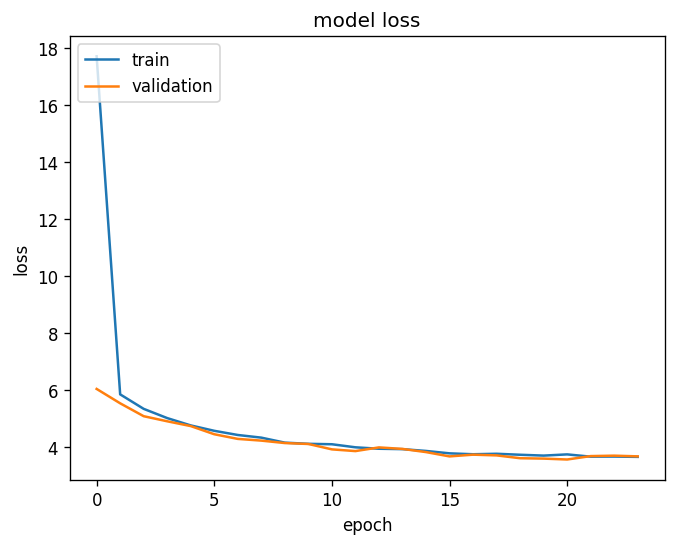

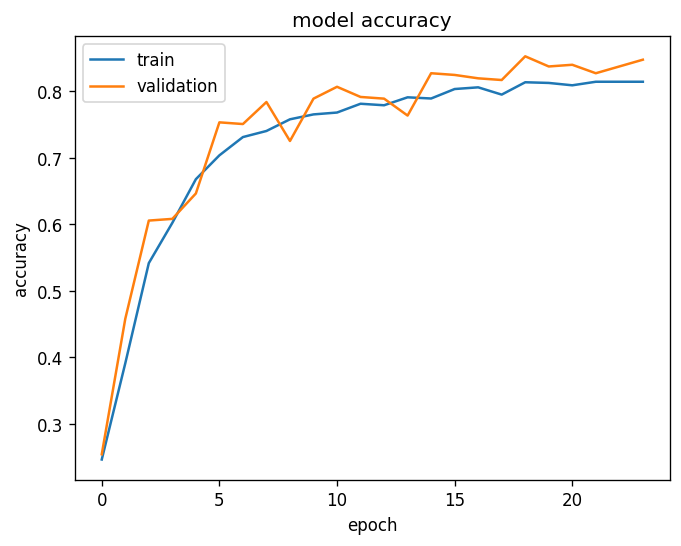

In [467]:
# print ('Test loss:', round(score[0], 3))
# print ('Test accuracy:', round(score[1]*100, 2),'%')
plt.figure(dpi=120)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.figure(dpi=120)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [468]:
# "images" sizes
X_train = X_VGF_train.copy()
X_val = X_VGF_val.copy()
y_train = y_VGF_train.copy()
y_val = y_VGF_val.copy()

n1 = X_train.shape[1]
n2 = X_train.shape[2]

print("Las imágenes son de ",n1,"x",n2)

# X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
# X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)
# X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
# X_train = X_train.astype('float32')
# X_test = X_test.astype('float32')

# normalizing the data to help with the training
# X_train /= 255
# X_test /= 255

# one-hot encoding using keras' numpy-related utilities
n_classes = 20
print("Shape before one-hot encoding: ", y_train.shape)
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_val = np_utils.to_categorical(y_val, n_classes)
# Y_test = np_utils.to_categorical(y_test, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)


model = Sequential()
# convolutional layer
model.add(Conv2D(25, kernel_size=(3,3), strides=(1,1), padding='valid', activation='leaky_relu', input_shape=(n1,n2,1)))
model.add(MaxPool2D(pool_size=(1,1)))
# flatten output of conv
model.add(Flatten())
# model.add(Dropout(0.2))
# hidden layer
model.add(Dense(64, activation='leaky_relu',kernel_regularizer=l1_l2(l1=0.01,l2=0.001)))
# model.add(BatchNormalization())
# model.add(Dense(64, activation='leaky_relu',kernel_regularizer=l1_l2(l1=0.01,l2=0.001)))
# model.add(BatchNormalization())
# output layer
model.add(Dense(20, activation='softmax'))

# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# training the model 

early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)
history = model.fit(X_train, Y_train, batch_size=32, epochs=100, validation_data=(X_val, Y_val)
            ,callbacks=[early_callback])

# score = model.evaluate(X_test, Y_test)

Las imágenes son de  10 x 100
Shape before one-hot encoding:  (3541,)
Shape after one-hot encoding:  (3541, 20)
Epoch 1/100
111/111 [==============================] - 1s 11ms/step - loss: 13.3143 - accuracy: 0.2251 - val_loss: 5.0139 - val_accuracy: 0.2926
Epoch 2/100
111/111 [==============================] - 1s 11ms/step - loss: 4.8831 - accuracy: 0.3798 - val_loss: 4.7596 - val_accuracy: 0.5318
Epoch 3/100
111/111 [==============================] - 1s 11ms/step - loss: 4.5773 - accuracy: 0.5270 - val_loss: 4.3762 - val_accuracy: 0.5751
Epoch 4/100
111/111 [==============================] - 1s 11ms/step - loss: 4.2563 - accuracy: 0.5970 - val_loss: 4.0356 - val_accuracy: 0.5776
Epoch 5/100
111/111 [==============================] - 1s 11ms/step - loss: 4.0573 - accuracy: 0.6332 - val_loss: 4.1238 - val_accuracy: 0.5827
Epoch 6/100
111/111 [==============================] - 1s 12ms/step - loss: 3.9351 - accuracy: 0.6662 - val_loss: 3.8873 - val_accuracy: 0.6209
Epoch 7/100
111/111 [==

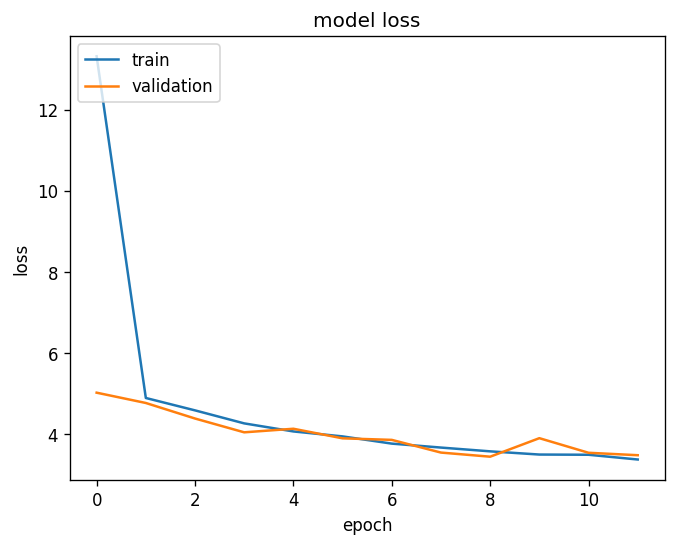

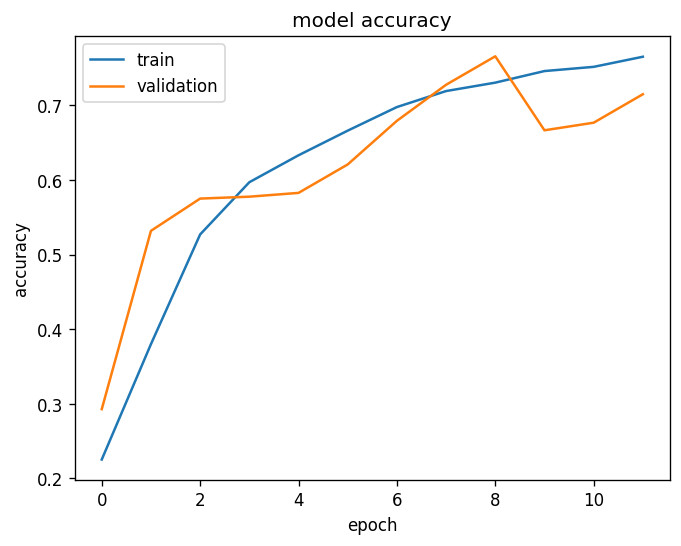

In [469]:
# print ('Test loss:', round(score[0], 3))
# print ('Test accuracy:', round(score[1]*100, 2),'%')
plt.figure(dpi=120)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.figure(dpi=120)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Predicciones con el modelo Top 10

#### Para TextRank

In [470]:
len(X_VTR_test)

984

In [471]:
pred = model.predict(tf.convert_to_tensor(X_VTR_test))
predictions = np.argmax(pred, axis=-1)

In [472]:
print(predictions)

[12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12

#### Para Grados de Fractalidad

In [473]:
print(predictions[2])

12


In [474]:
pred = model.predict(tf.convert_to_tensor(X_VGF_test))
print(pred)
predictions = np.argmax(pred, axis=-1)

[[0.04132663 0.04938328 0.03201245 ... 0.04903255 0.05815673 0.03339017]
 [0.04132609 0.04937987 0.03201045 ... 0.04903105 0.05815636 0.03339004]
 [0.04132663 0.04938328 0.03201245 ... 0.04903255 0.05815673 0.03339017]
 ...
 [0.04132663 0.04938328 0.03201245 ... 0.04903255 0.05815673 0.03339017]
 [0.04132663 0.04938328 0.03201245 ... 0.04903255 0.05815673 0.03339017]
 [0.04132613 0.04938097 0.03201126 ... 0.04903101 0.05815653 0.03338983]]


In [475]:
print(predictions)

[12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12

In [476]:
for i in range(len(predictions)):
    if predictions[i] != 12:
        print(i)

748
934


In [479]:
test_backup.iloc[934]

docs      gretzky average ptsgame check information post...
target                                                   10
TR        [pt, percentage, canadien, record, games, info...
GF        [percentage, games, record, canadien, gretzkys...
Name: 934, dtype: object

## Lee matrices de entrenamiento (Top 5)

In [431]:
X_VTR_train = np.load('X_VTR_train.npy', allow_pickle=True)
y_VTR_train = np.load('y_VTR_train.npy', allow_pickle=True)
X_VTR_val = np.load('X_VTR_val.npy', allow_pickle=True)
y_VTR_val = np.load('y_VTR_val.npy', allow_pickle=True)
X_VTR_test = np.load('X_VTR_test.npy', allow_pickle=True)

X_VGF_train = np.load('X_VGF_train.npy', allow_pickle=True)
y_VGF_train = np.load('y_VGF_train.npy', allow_pickle=True)
X_VGF_val = np.load('X_VGF_val.npy', allow_pickle=True)
y_VGF_val = np.load('y_VGF_val.npy', allow_pickle=True)
X_VGF_test = np.load('X_VGF_test.npy', allow_pickle=True)

In [432]:
print(X_VTR_train.shape, y_VTR_train.shape)
print(X_VGF_train.shape, y_VGF_train.shape)

print(X_VTR_val.shape, y_VTR_val.shape)
print(X_VGF_val.shape, y_VGF_val.shape)

print(X_VTR_test.shape)
print(X_VGF_test.shape)

(3934, 10, 100) (3934,)
(3541, 10, 100) (3541,)
(393, 10, 100) (393,)
(393, 10, 100) (393,)
(984, 10, 100)
(984, 10, 100)


In [434]:

X_VTR_train = X_VTR_train.reshape(X_VTR_train.shape[0], X_VTR_train.shape[1], X_VTR_train.shape[2], 1)[:,:5,:,:]
X_VTR_train = X_VTR_train.astype('float32')

X_VGF_train = X_VGF_train.reshape(X_VGF_train.shape[0], X_VGF_train.shape[1], X_VGF_train.shape[2], 1)[:,:5,:,:]
X_VGF_train = X_VGF_train.astype('float32')

X_VTR_val = X_VTR_val.reshape(X_VTR_val.shape[0], X_VTR_val.shape[1], X_VTR_val.shape[2], 1)[:,:5,:,:]
X_VTR_val = X_VTR_val.astype('float32')

X_VGF_val = X_VGF_val.reshape(X_VGF_val.shape[0], X_VGF_val.shape[1], X_VGF_val.shape[2], 1)[:,:5,:,:]
X_VGF_val = X_VGF_val.astype('float32')

X_VTR_test = X_VTR_test.reshape(X_VTR_test.shape[0], X_VTR_test.shape[1], X_VTR_test.shape[2], 1)[:,:5,:,:]

X_VGF_test = X_VGF_test.reshape(X_VGF_test.shape[0], X_VGF_test.shape[1], X_VGF_test.shape[2], 1)[:,:5,:,:]

print(X_VTR_train.shape)
print(y_VTR_train.shape)

print(X_VGF_train.shape)
print(y_VGF_train.shape)

print(X_VTR_test.shape)

print(X_VGF_test.shape)

(3934, 5, 100, 1)
(3934,)
(3541, 5, 100, 1)
(3541,)
(984, 5, 100, 1)
(984, 5, 100, 1)


# Clasificación usando CNN

In [435]:
# "images" sizes
X_train = X_VTR_train.copy()
X_val = X_VTR_val.copy()
y_train = y_VTR_train.copy()
y_val = y_VTR_val.copy()

n1 = X_train.shape[1]
n2 = X_train.shape[2]

print("Las imágenes son de ",n1,"x",n2)

# X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
# X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)
# X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
# X_train = X_train.astype('float32')
# X_test = X_test.astype('float32')

# normalizing the data to help with the training
# X_train /= 255
# X_test /= 255

# one-hot encoding using keras' numpy-related utilities
n_classes = 20
print("Shape before one-hot encoding: ", y_train.shape)
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_val = np_utils.to_categorical(y_val, n_classes)
# Y_test = np_utils.to_categorical(y_test, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)


model = Sequential()
# convolutional layer
model.add(Conv2D(25, kernel_size=(3,3), strides=(1,1), padding='valid', activation='leaky_relu', input_shape=(n1,n2,1)))
model.add(MaxPool2D(pool_size=(1,1)))
# flatten output of conv
model.add(Flatten())
model.add(Dropout(0.2))
# hidden layer
model.add(Dense(100, activation='leaky_relu',kernel_regularizer=l1_l2(l1=0.01,l2=0.001)))
model.add(BatchNormalization())
# model.add(Dense(64, activation='leaky_relu',kernel_regularizer=l1_l2(l1=0.01,l2=0.001)))
# model.add(BatchNormalization())
# output layer
model.add(Dense(20, activation='softmax'))

# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# training the model 

early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
history = model.fit(X_train, Y_train, batch_size=32, epochs=100, validation_data=(X_val, Y_val)
            ,callbacks=[early_callback])

# score = model.evaluate(X_test, Y_test)

Las imágenes son de  5 x 100
Shape before one-hot encoding:  (3934,)
Shape after one-hot encoding:  (3934, 20)
Epoch 1/100
123/123 [==============================] - 1s 9ms/step - loss: 18.6656 - accuracy: 0.5475 - val_loss: 6.1521 - val_accuracy: 0.4580
Epoch 2/100
123/123 [==============================] - 1s 8ms/step - loss: 4.8292 - accuracy: 0.5963 - val_loss: 5.0726 - val_accuracy: 0.6438
Epoch 3/100
123/123 [==============================] - 1s 8ms/step - loss: 3.9262 - accuracy: 0.6393 - val_loss: 4.0328 - val_accuracy: 0.6285
Epoch 4/100
123/123 [==============================] - 1s 8ms/step - loss: 3.5574 - accuracy: 0.6495 - val_loss: 3.4802 - val_accuracy: 0.6845
Epoch 5/100
123/123 [==============================] - 1s 8ms/step - loss: 3.2889 - accuracy: 0.6729 - val_loss: 3.3107 - val_accuracy: 0.6870
Epoch 6/100
123/123 [==============================] - 1s 9ms/step - loss: 3.1820 - accuracy: 0.6723 - val_loss: 3.1574 - val_accuracy: 0.6387
Epoch 7/100
123/123 [=========

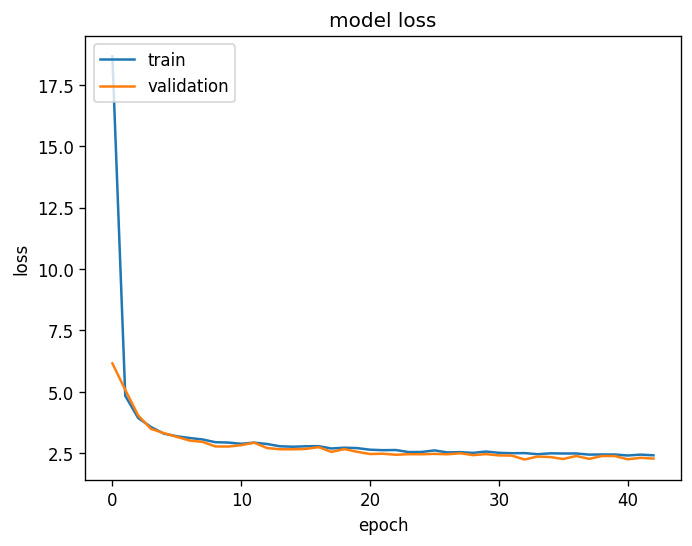

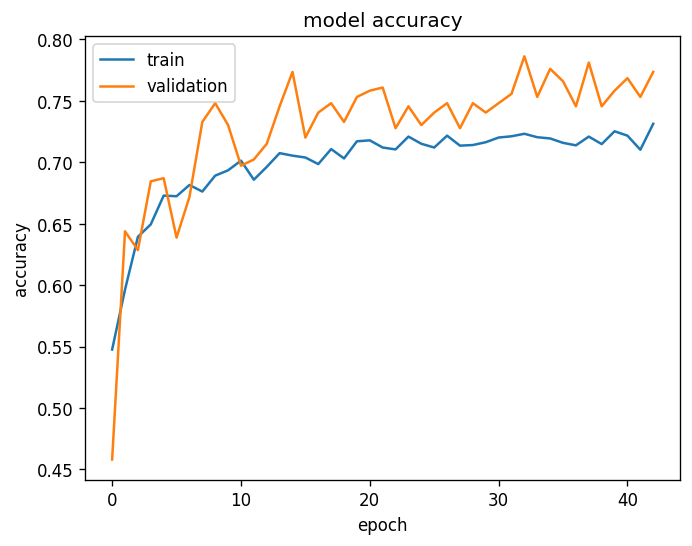

In [436]:
# print ('Test loss:', round(score[0], 3))
# print ('Test accuracy:', round(score[1]*100, 2),'%')
plt.figure(dpi=120)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.figure(dpi=120)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [437]:
# "images" sizes
X_train = X_VGF_train.copy()
X_val = X_VGF_val.copy()
y_train = y_VGF_train.copy()
y_val = y_VGF_val.copy()

n1 = X_train.shape[1]
n2 = X_train.shape[2]

print("Las imágenes son de ",n1,"x",n2)

# X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
# X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)
# X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
# X_train = X_train.astype('float32')
# X_test = X_test.astype('float32')

# normalizing the data to help with the training
# X_train /= 255
# X_test /= 255

# one-hot encoding using keras' numpy-related utilities
n_classes = 20
print("Shape before one-hot encoding: ", y_train.shape)
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_val = np_utils.to_categorical(y_val, n_classes)
# Y_test = np_utils.to_categorical(y_test, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)


model = Sequential()
# convolutional layer
model.add(Conv2D(25, kernel_size=(3,3), strides=(1,1), padding='valid', activation='leaky_relu', input_shape=(n1,n2,1)))
model.add(MaxPool2D(pool_size=(1,1)))
# flatten output of conv
model.add(Flatten())
model.add(Dropout(0.2))
# hidden layer
model.add(Dense(128, activation='leaky_relu',kernel_regularizer=l1_l2(l1=0.01,l2=0.001)))
model.add(BatchNormalization())
model.add(Dense(64, activation='leaky_relu'))
model.add(BatchNormalization())
# output layer
model.add(Dense(20, activation='softmax'))

# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# training the model 

early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
history = model.fit(X_train, Y_train, batch_size=32, epochs=100, validation_data=(X_val, Y_val)
            ,callbacks=[early_callback])

# score = model.evaluate(X_test, Y_test)

Las imágenes son de  5 x 100
Shape before one-hot encoding:  (3541,)
Shape after one-hot encoding:  (3541, 20)
Epoch 1/100
111/111 [==============================] - 2s 10ms/step - loss: 24.6589 - accuracy: 0.5270 - val_loss: 7.6165 - val_accuracy: 0.2799
Epoch 2/100
111/111 [==============================] - 1s 9ms/step - loss: 5.9103 - accuracy: 0.5787 - val_loss: 6.0866 - val_accuracy: 0.3639
Epoch 3/100
111/111 [==============================] - 1s 8ms/step - loss: 4.6381 - accuracy: 0.6354 - val_loss: 5.1171 - val_accuracy: 0.4326
Epoch 4/100
111/111 [==============================] - 1s 8ms/step - loss: 4.1233 - accuracy: 0.6507 - val_loss: 4.3165 - val_accuracy: 0.5852
Epoch 5/100
111/111 [==============================] - 1s 8ms/step - loss: 3.8288 - accuracy: 0.6622 - val_loss: 3.9677 - val_accuracy: 0.6768
Epoch 6/100
111/111 [==============================] - 1s 9ms/step - loss: 3.6746 - accuracy: 0.6741 - val_loss: 3.7241 - val_accuracy: 0.6616
Epoch 7/100
111/111 [========

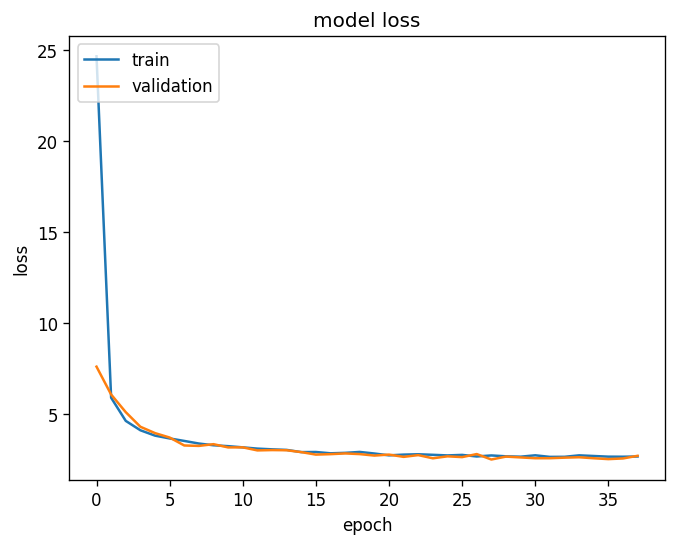

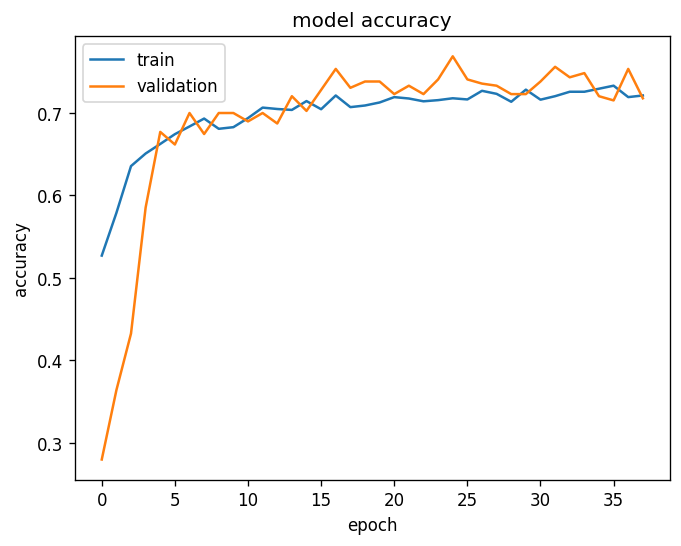

In [438]:
# print ('Test loss:', round(score[0], 3))
# print ('Test accuracy:', round(score[1]*100, 2),'%')
plt.figure(dpi=120)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.figure(dpi=120)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### TEST del modelo con el dataframe de test

In [125]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 3, 98, 25)         250       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 3, 98, 25)        0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 7350)              0         
                                                                 
 dropout_1 (Dropout)         (None, 7350)              0         
                                                                 
 dense_6 (Dense)             (None, 128)               940928    
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                      

In [327]:
test

,TR_values,GF_values
0,"[[2.1591932525722355e-34, 1.1008670817698768e-...","[[1.1053014872534575e-25, 6.244326609852006e-2..."
1,"[[0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0...","[[4.162948243902065e-06, 2.6631594664650038e-0..."
2,"[[-0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -...","[[-3.2456486328009055e-25, 4.75931469121995e-2..."
3,"[[-0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -...","[[-1.933069329607129e-11, 7.719130890038173e-1..."
4,"[[0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -...","[[0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -..."
...,...,...
979,"[[4.5276427e-09, 3.770582e-08, 9.515052e-09, -...","[[-8.105121e-06, 4.2033457e-06, 1.3830629e-05,..."
980,"[[-3.604184e-33, 9.827001e-34, 1.1905191e-33, ...","[[-1.6260956e-12, 1.0072741e-12, 2.044487e-12,..."
981,"[[-0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -...","[[-1.2096627e-15, 3.1774805e-16, 1.4383589e-15..."
982,"[[-0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -...","[[-0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -..."


In [326]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   TR_values  984 non-null    object
 1   GF_values  984 non-null    object
dtypes: object(2)
memory usage: 15.5+ KB


In [444]:
placeholder = test.TR_values.values

In [ ]:
placeholder

In [452]:
pred = model.predict(tf.convert_to_tensor(X_VTR_test))
predictions = np.argmax(pred, axis=-1)

print(predictions)

[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15

In [440]:
pred = model.predict(tf.convert_to_tensor(X_VGF_test))
predictions = np.argmax(pred, axis=-1)

print(predictions)

[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15

In [453]:
with np.printoptions(threshold=np.inf):
    print(len(test.iloc[0].TR_values))


100


In [480]:
test

,TR_values,GF_values
0,"[[2.1591932525722355e-34, 1.1008670817698768e-...","[[1.1053014872534575e-25, 6.244326609852006e-2..."
1,"[[0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0...","[[4.162948243902065e-06, 2.6631594664650038e-0..."
2,"[[-0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -...","[[-3.2456486328009055e-25, 4.75931469121995e-2..."
3,"[[-0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -...","[[-1.933069329607129e-11, 7.719130890038173e-1..."
4,"[[0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -...","[[0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -..."
...,...,...
979,"[[4.527642705198787e-09, 3.770582068796102e-08...","[[-8.10512119642226e-06, 4.203345724818064e-06..."
980,"[[-3.604183963740185e-33, 9.827001448114818e-3...","[[-1.6260956340122257e-12, 1.007274125219837e-..."
981,"[[-0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -...","[[-1.2096626809295617e-15, 3.177480518386569e-..."
982,"[[-0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -...","[[-0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -..."
